# `OLA - Ensemble Learning`

## Problem Statement

Recruiting and retaining drivers is seen by industry watchers as a tough battle for Ola. churn among drivers is high and it’s very easy for drivers to stop working for the service on the fly or jump to Uber depending on the rates.

As the companies get bigger, the high churn could become a bigger problem. To find new drivers, Ola is casting a wide net, including people who don’t have cars for jobs. But this acquisition is really costly. Losing drivers frequently impacts the morale of the organization and acquiring new drivers is more expensive than retaining existing ones.

You are working as a data scientist with the Analytics Department of Ola, focused on driver team attrition. You are provided with the monthly information for a segment of drivers for 2019 and 2020 and tasked to predict whether a driver will be leaving the company or not based on their attributes like

- Demographics (city, age, gender etc.)
- Tenure information (joining date, Last Date)
- Historical data regarding the performance of the driver (Quarterly rating, Monthly business acquired, grade, Income)

## Column Profiling:

1) MMMM-YY : Reporting Date (Monthly)
2) Driver_ID : Unique id for drivers
3) Age : Age of the driver
4) Gender : Gender of the driver – Male : 0, Female: 1
5) City : City Code of the driver
6) Education_Level : Education level – 0 for 10+ ,1 for 12+ ,2 for graduate
7) Income : Monthly average Income of the driver
8) Date Of Joining : Joining date for the driver
9) LastWorkingDate : Last date of working for the driver
10) Joining Designation : Designation of the driver at the time of joining
11) Grade : Grade of the driver at the time of reporting
12) Total Business Value : The total business value acquired by the driver in a month (negative business indicates cancellation/refund or car EMI adjustments)
13) Quarterly Rating : Quarterly rating of the driver: 1,2,3,4,5 (higher is better)

In [4]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from datetime import datetime
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, label_binarize
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, validation_curve, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.multiclass import OneVsRestClassifier
from imblearn.over_sampling import SMOTE
from scipy.stats import randint
from xgboost import XGBClassifier

warnings.filterwarnings("ignore")

## Exploratory Data Analysis

In [6]:
df=pd.read_csv('ola_driver_scaler.csv')

In [7]:
df.head()

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


### Observations on Data

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            19104 non-null  int64  
 1   MMM-YY                19104 non-null  object 
 2   Driver_ID             19104 non-null  int64  
 3   Age                   19043 non-null  float64
 4   Gender                19052 non-null  float64
 5   City                  19104 non-null  object 
 6   Education_Level       19104 non-null  int64  
 7   Income                19104 non-null  int64  
 8   Dateofjoining         19104 non-null  object 
 9   LastWorkingDate       1616 non-null   object 
 10  Joining Designation   19104 non-null  int64  
 11  Grade                 19104 non-null  int64  
 12  Total Business Value  19104 non-null  int64  
 13  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(8), object(4)
memory usage: 2.0+ MB


In [10]:
df.shape

(19104, 14)

In [11]:
df.isna().sum().sort_values(ascending=False)

LastWorkingDate         17488
Age                        61
Gender                     52
Unnamed: 0                  0
MMM-YY                      0
Driver_ID                   0
City                        0
Education_Level             0
Income                      0
Dateofjoining               0
Joining Designation         0
Grade                       0
Total Business Value        0
Quarterly Rating            0
dtype: int64

In [12]:
def missing_data(df):
    total_missing_df = df.isnull().sum().sort_values(ascending =False)
    percent_missing_df = (df.isnull().sum()/df.isna().count()*100).sort_values(ascending=False)
    missing_data_df = pd.concat([total_missing_df, percent_missing_df], axis=1, keys=['Total', 'Percent'])
    return missing_data_df

missing_pct = missing_data(df)
missing_pct

,Total,Percent
LastWorkingDate,17488,91.541039
Age,61,0.319305
Gender,52,0.272194
Unnamed: 0,0,0.000000
MMM-YY,0,0.000000
Driver_ID,0,0.000000
City,0,0.000000
Education_Level,0,0.000000
Income,0,0.000000
Dateofjoining,0,0.000000


### <span style="color:seagreen"><strong>Insights:</strong></span>

> Following columns has missing values
- LastWorkingDate has **91.54%** missing values
- Age has **0.32%** missing values
- Gender has **0.27%** missing values

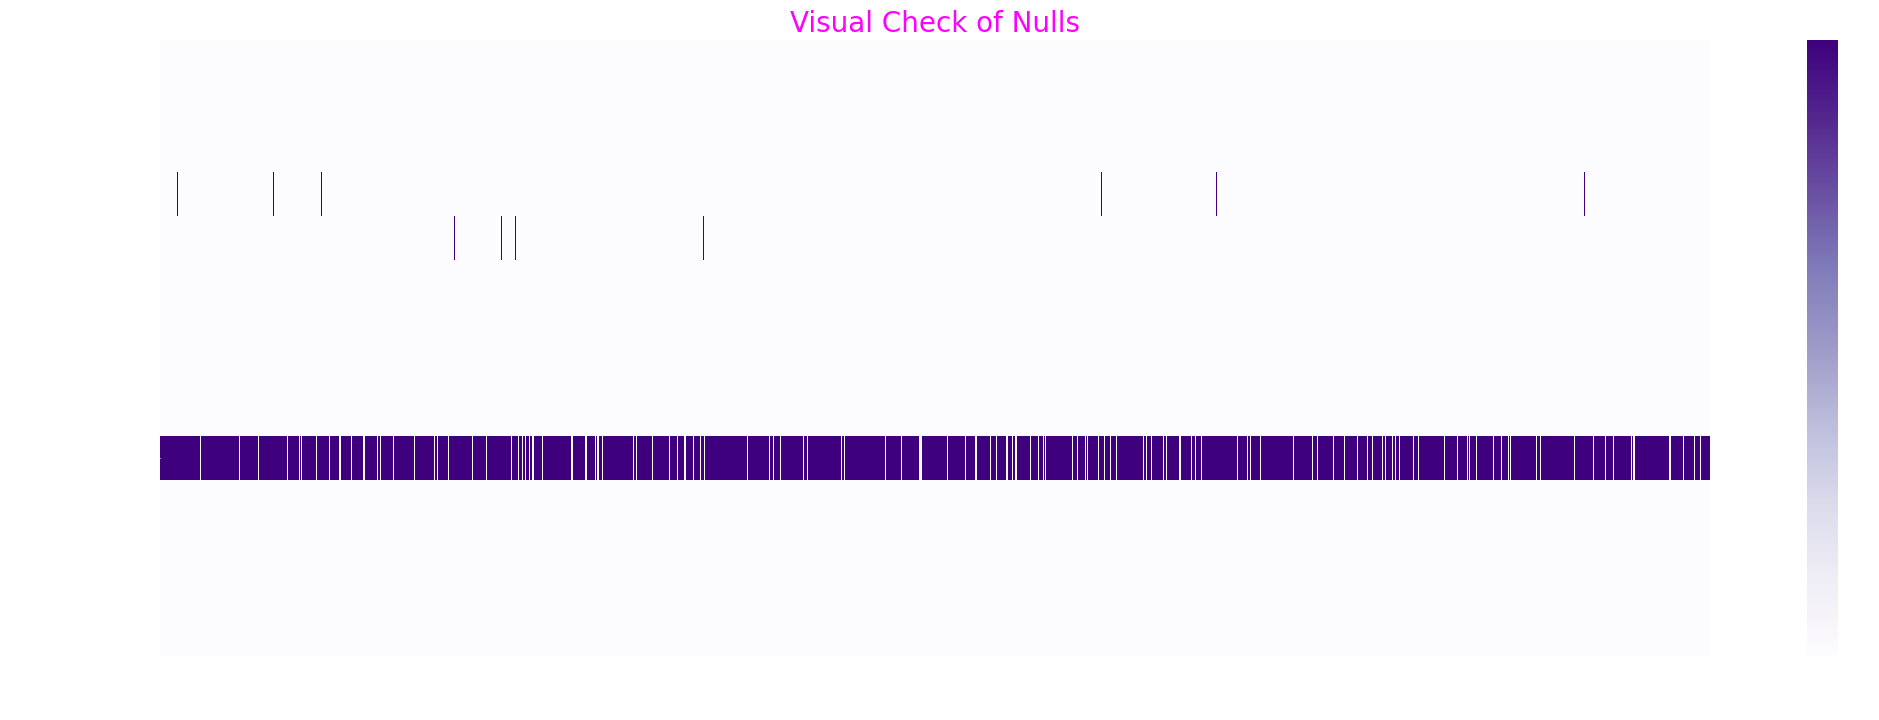

In [14]:
plt.figure(figsize=(25,8))
plt.style.use('dark_background')
sns.heatmap(df.isnull().T,cmap='Purples')
plt.title('Visual Check of Nulls',fontsize=20,color='magenta')
plt.show()

In [15]:
df.nunique()

Unnamed: 0              19104
MMM-YY                     24
Driver_ID                2381
Age                        36
Gender                      2
City                       29
Education_Level             3
Income                   2383
Dateofjoining             869
LastWorkingDate           493
Joining Designation         5
Grade                       5
Total Business Value    10181
Quarterly Rating            4
dtype: int64

In [16]:
df.duplicated().value_counts()

False    19104
Name: count, dtype: int64

In [17]:
df.describe()

,Unnamed: 0,Driver_ID,Age,Gender,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating
count,19104.000000,19104.000000,19043.000000,19052.000000,19104.000000,19104.000000,19104.000000,19104.000000,1.910400e+04,19104.000000
mean,9551.500000,1415.591133,34.668435,0.418749,1.021671,65652.025126,1.690536,2.252670,5.716621e+05,2.008899
std,5514.994107,810.705321,6.257912,0.493367,0.800167,30914.515344,0.836984,1.026512,1.128312e+06,1.009832
min,0.000000,1.000000,21.000000,0.000000,0.000000,10747.000000,1.000000,1.000000,-6.000000e+06,1.000000
25%,4775.750000,710.000000,30.000000,0.000000,0.000000,42383.000000,1.000000,1.000000,0.000000e+00,1.000000
50%,9551.500000,1417.000000,34.000000,0.000000,1.000000,60087.000000,1.000000,2.000000,2.500000e+05,2.000000
75%,14327.250000,2137.000000,39.000000,1.000000,2.000000,83969.000000,2.000000,3.000000,6.997000e+05,3.000000
max,19103.000000,2788.000000,58.000000,1.000000,2.000000,188418.000000,5.000000,5.000000,3.374772e+07,4.000000


In [18]:
df.describe(include='object')

,MMM-YY,City,Dateofjoining,LastWorkingDate
count,19104,19104,19104,1616
unique,24,29,869,493
top,01/01/19,C20,23/07/15,29/07/20
freq,1022,1008,192,70


### <span style="color:seagreen"><strong>Insights:</strong></span>
- There are **19104** entries with 14 columns
- There are **61 null/missing values in *Age*, 52 in *Gender* and 17488 in *LastWorkingDate***
- There are **2381 unique drivers**
- There are no **duplicates**
- The column ***Unnamed: 0*** can be dropped as it doesnt provide any new information
- The columns ***Gender, City, Education_Level, Joining Designation, Grade*** and  ***Quarterly Rating*** can be converted to **categorical** datatype
- The columns ***MMM-YY, Dateofjoining*** and ***LastWorkingDate*** can be converted to **datetime** datatype
- Drivers who have valid ***LastWorkingDate*** can be considered as **churned**

In [20]:
# Drop "Unnamed: 0" column
df.drop(columns=['Unnamed: 0'], inplace=True)

In [21]:
# Convert to category
categorical_columns = ['Gender', 'City', 'Education_Level', 'Joining Designation', 'Grade']
df[categorical_columns] = df[categorical_columns].astype('category')
df['Gender'].replace({0.0:'Male', 1.0: 'Female'}, inplace=True)
df['Education_Level'].replace({0:'10+', 1:'12+', 2:'Graduate'}, inplace=True)

In [22]:
# Convert to datetime
df['MMM-YY'] = pd.to_datetime(df['MMM-YY'], format='%m/%d/%y')
df['Dateofjoining'] = pd.to_datetime(df['Dateofjoining'], format='%d/%m/%y')
df['LastWorkingDate'] = pd.to_datetime(df['LastWorkingDate'], format='%d/%m/%y')

In [23]:
# Rename 'MMM-YY' to 'ReportingMonthYear'
df.rename(columns={'MMM-YY':'ReportingMonthYear'}, inplace=True)
df['ReportingMonthYear'] = df['ReportingMonthYear'].dt.to_period('M')
df['ReportingYear'] = df['ReportingMonthYear'].dt.year

In [24]:
# Extract month and year from 'Dateofjoining'
df['Monthofjoining'] = df['Dateofjoining'].dt.month
df['Yearofjoining'] = df['Dateofjoining'].dt.year

In [25]:
# Find drivers who haved churned
df['churn'] = df.groupby('Driver_ID')['LastWorkingDate'].transform('last')
df['churn'] = df['churn'].apply(lambda x: 0 if pd.isnull(x) else 1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ReportingMonthYear    19104 non-null  period[M]     
 1   Driver_ID             19104 non-null  int64         
 2   Age                   19043 non-null  float64       
 3   Gender                19052 non-null  category      
 4   City                  19104 non-null  category      
 5   Education_Level       19104 non-null  category      
 6   Income                19104 non-null  int64         
 7   Dateofjoining         19104 non-null  datetime64[ns]
 8   LastWorkingDate       1616 non-null   datetime64[ns]
 9   Joining Designation   19104 non-null  category      
 10  Grade                 19104 non-null  category      
 11  Total Business Value  19104 non-null  int64         
 12  Quarterly Rating      19104 non-null  int64         
 13  ReportingYear   

### Univariate Analysis

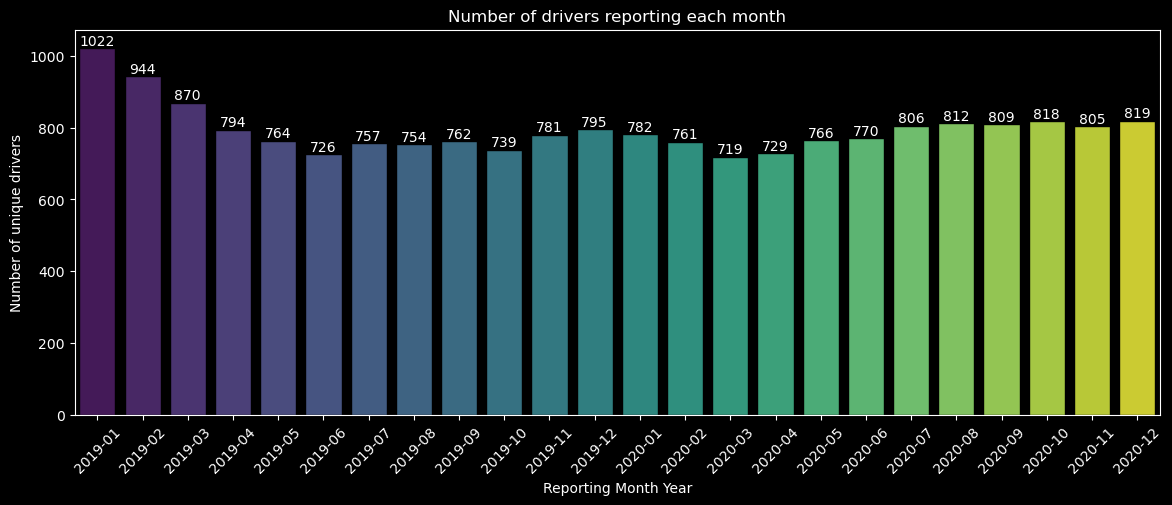

In [27]:
# Prepare the data
temp_df = df.groupby('ReportingMonthYear')['Driver_ID'].nunique().reset_index()

# Set figure size
plt.figure(figsize=(14, 5))

# Create a bar plot
ax = sns.barplot(data=temp_df, x='ReportingMonthYear', y='Driver_ID', palette='viridis', edgecolor='black')

# Add labels to bars
for container in ax.containers:
    ax.bar_label(container)

# Labels and title
plt.ylabel('Number of unique drivers')
plt.xlabel('Reporting Month Year')
plt.title('Number of drivers reporting each month')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.show()


### <span style="color:seagreen"><strong>Insights:</strong></span>
- The **month** during which **maximum** number of **drivers reported is January 2019**. A total of **1022 drivers** reported on January 2019
- It then dropeed every month after January and has been stagnant at around 800 drivers reported every month

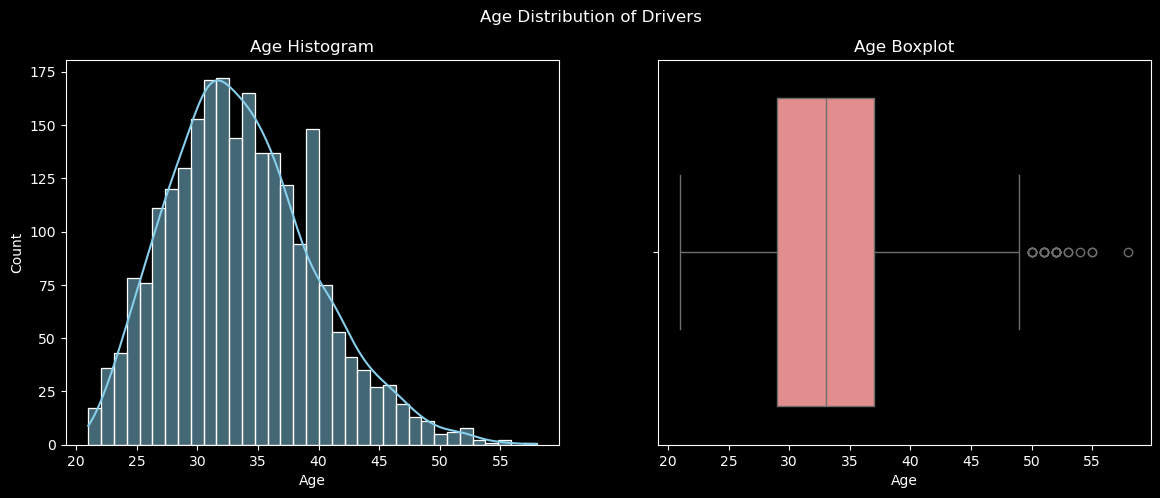

In [29]:
# Prepare the data
temp_df = df.groupby('Driver_ID').agg({'Age': 'last'})['Age']

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Histogram with Seaborn
sns.histplot(temp_df, bins=35, kde=True, ax=axs[0], color='skyblue')
axs[0].set_title('Age Histogram')

# Boxplot with Seaborn
sns.boxplot(x=temp_df, ax=axs[1], color='lightcoral')
axs[1].set_title('Age Boxplot')

# Set a main title
fig.suptitle('Age Distribution of Drivers')

# Show plot
plt.show()


### <span style="color:seagreen"><strong>Insights:</strong></span>
- There are drivers from different **age** groups ranging from **21 to 58 years**
- **Most** of the drivers are in the age group of **30 to 35**
- The distribution is mostly **normal** with **little skewness** towards the **right**

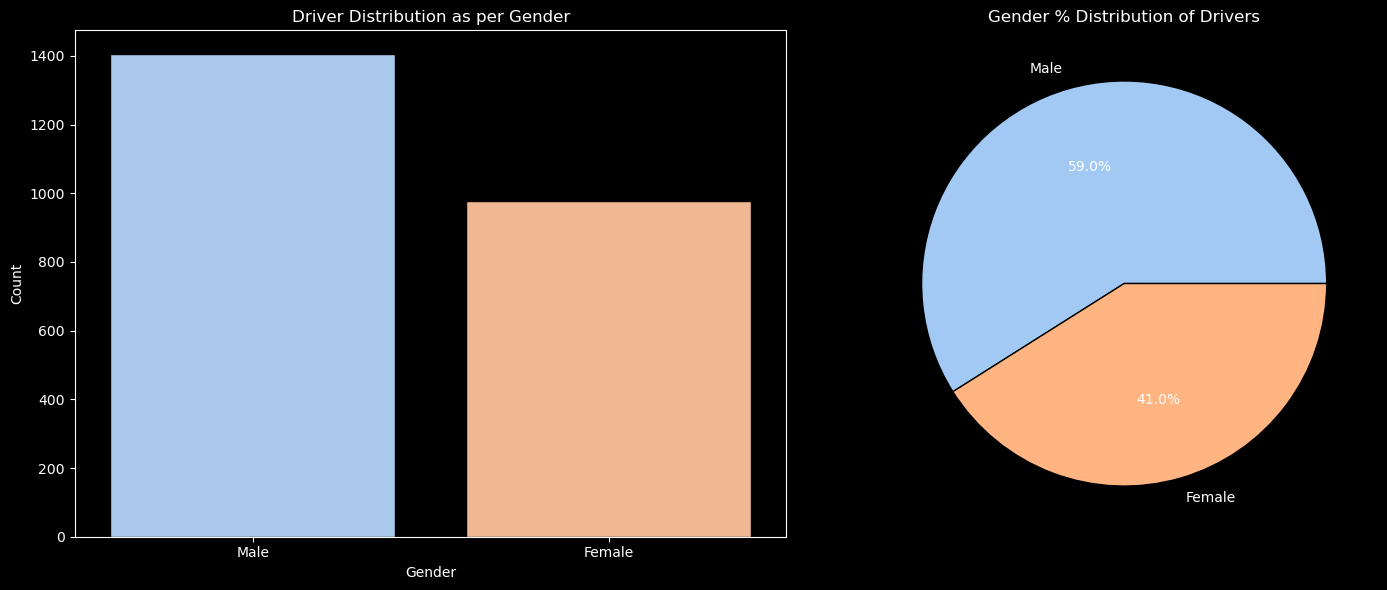

In [31]:
# Prepare the data
temp_df = df.groupby('Driver_ID').agg({'Gender': 'first'})

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Bar plot using Seaborn
sns.barplot(
    x=temp_df['Gender'].value_counts().index, 
    y=temp_df['Gender'].value_counts().values, 
    ax=axs[0], 
    palette='pastel', edgecolor='black'
)

# Set bar plot labels
axs[0].set_xlabel('Gender')
axs[0].set_ylabel('Count')
axs[0].set_title('Driver Distribution as per Gender')

# Pie chart using Matplotlib (since Seaborn does not support pie charts)
temp_df['Gender'].value_counts().plot(
    kind='pie', 
    ax=axs[1], 
    autopct='%.1f%%', 
    colors=sns.color_palette('pastel'),
    wedgeprops={'edgecolor': 'black'}
)

# Adjust pie chart labels
axs[1].set_ylabel('')  # Remove y-axis label
axs[1].set_title('Gender % Distribution of Drivers')

# Show plot
plt.tight_layout()
plt.show()


### <span style="color:seagreen"><strong>Insights:</strong></span>
- **59%** of the drivers are **Male** and remaining **41%** are **Female**

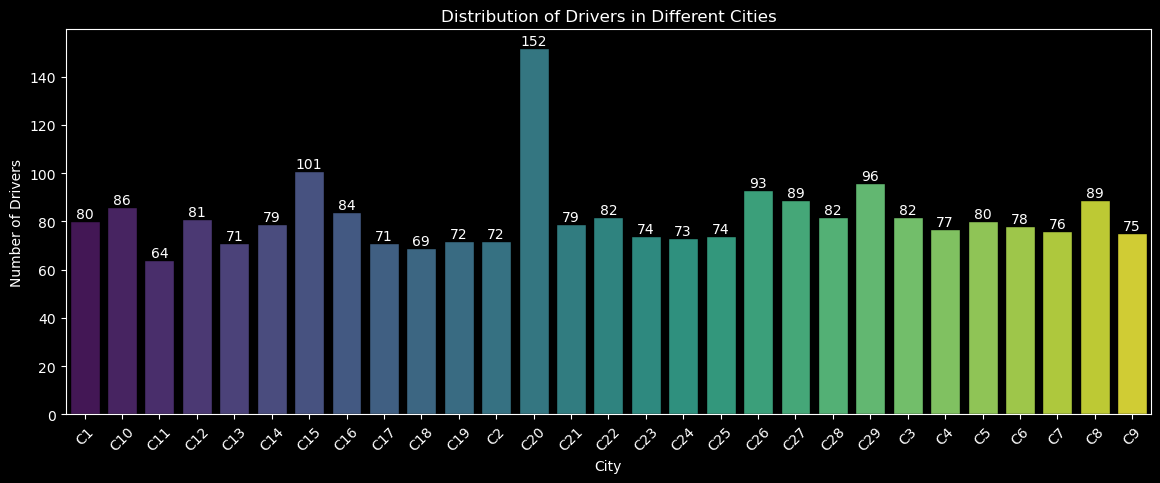

In [33]:
# Prepare the data
temp_df = df.groupby('Driver_ID').agg({'City': 'first'})

# Set figure size
plt.figure(figsize=(14, 5))

# Create bar plot using Seaborn
ax = sns.barplot(
    x=temp_df['City'].value_counts().index, 
    y=temp_df['City'].value_counts().values, 
    palette='viridis', edgecolor='black'
)

# Add bar labels
for container in ax.containers:
    ax.bar_label(container)

# Titles and labels
plt.xlabel('City')
plt.ylabel('Number of Drivers')
plt.title('Distribution of Drivers in Different Cities')

# Rotate x-axis labels for better readability if needed
plt.xticks(rotation=45)

# Show plot
plt.show()


### <span style="color:seagreen"><strong>Insights:</strong></span>
- City **C20** has the **maximum** number of **drivers** followed by city C15 

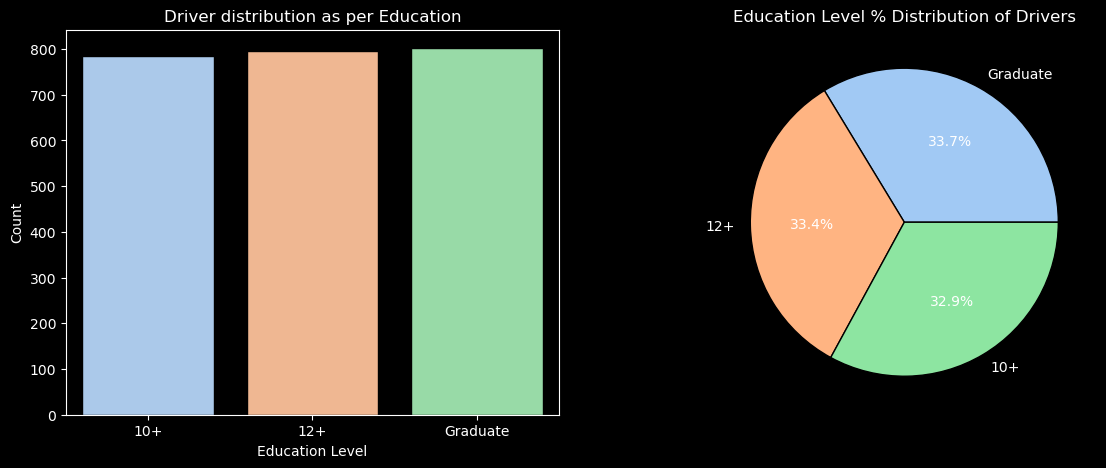

In [35]:
# Prepare the data
temp_df = df.groupby('Driver_ID').agg({'Education_Level': 'first'})

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot using Seaborn
sns.barplot(
    x=temp_df['Education_Level'].value_counts().index, 
    y=temp_df['Education_Level'].value_counts().values, 
    ax=axs[0], 
    palette='pastel',edgecolor='black'
)
axs[0].set_xlabel('Education Level')
axs[0].set_ylabel('Count')
axs[0].set_title('Driver distribution as per Education')

# Pie chart using Matplotlib (Seaborn does not have a built-in pie chart)
temp_df['Education_Level'].value_counts().plot(kind='pie', ax=axs[1], autopct='%.1f%%', colors=sns.color_palette('pastel'),wedgeprops={'edgecolor': 'black'})
axs[1].set_ylabel('')  # Remove y-axis label
axs[1].set_title('Education Level % Distribution of Drivers')

# Show plot
plt.show()


### <span style="color:seagreen"><strong>Insights:</strong></span>
- Almost equal proportion of drivers are from the 3 different education level

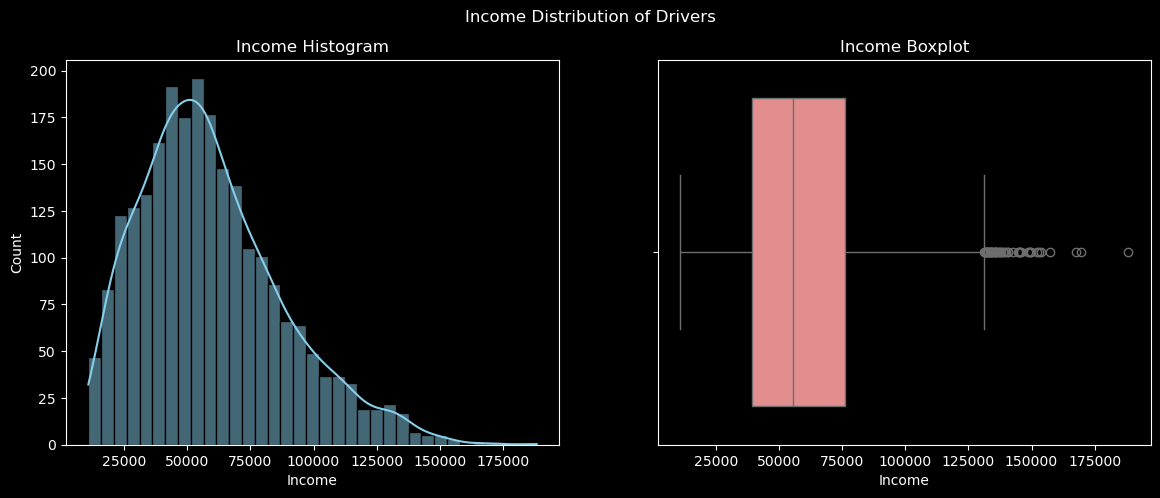

In [37]:
# Prepare the data
temp_df = df.groupby('Driver_ID').agg({'Income': 'last'})['Income']

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Histogram using Seaborn
sns.histplot(temp_df, bins=35, kde=True, ax=axs[0], color='skyblue', edgecolor='black')
axs[0].set_title('Income Histogram')
axs[0].set_xlabel('Income')

# Boxplot using Seaborn
sns.boxplot(x=temp_df, ax=axs[1], color='lightcoral')
axs[1].set_title('Income Boxplot')

# Set a main title
fig.suptitle('Income Distribution of Drivers')

# Show plot
plt.show()


### <span style="color:seagreen"><strong>Insights:</strong></span>
- Most of the drivers have an average monthly income of **40k to 75k**
- The distribution is **right skewed**

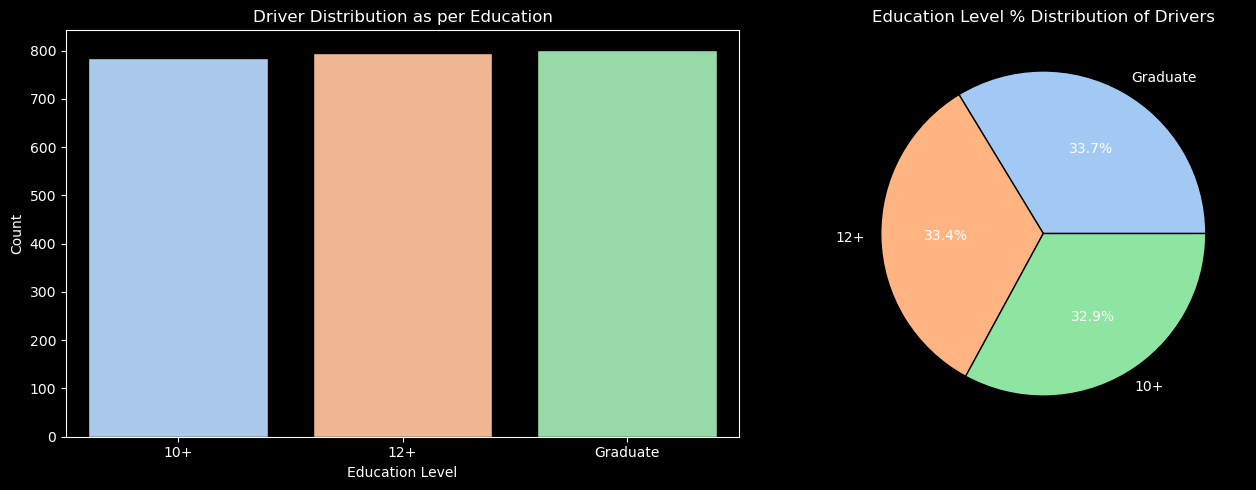

In [39]:
# Prepare the data
temp_df = df.groupby('Driver_ID').agg({'Education_Level': 'first'})

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot using Seaborn
sns.barplot(
    x=temp_df['Education_Level'].value_counts().index, 
    y=temp_df['Education_Level'].value_counts().values, 
    ax=axs[0], 
    palette='pastel', edgecolor='black'
)

# Set bar plot labels
axs[0].set_xlabel('Education Level')
axs[0].set_ylabel('Count')
axs[0].set_title('Driver Distribution as per Education')

# Pie chart using Matplotlib (Seaborn does not support pie charts directly)
temp_df['Education_Level'].value_counts().plot(
    kind='pie', 
    ax=axs[1], 
    autopct='%.1f%%', 
    colors=sns.color_palette('pastel'),
    wedgeprops={'edgecolor': 'black'}
)

# Adjust pie chart labels
axs[1].set_ylabel('')  # Remove y-axis label
axs[1].set_title('Education Level % Distribution of Drivers')

# Show plot
plt.tight_layout()
plt.show()


### <span style="color:seagreen"><strong>Insights:</strong></span>
- All education level almost same percentage

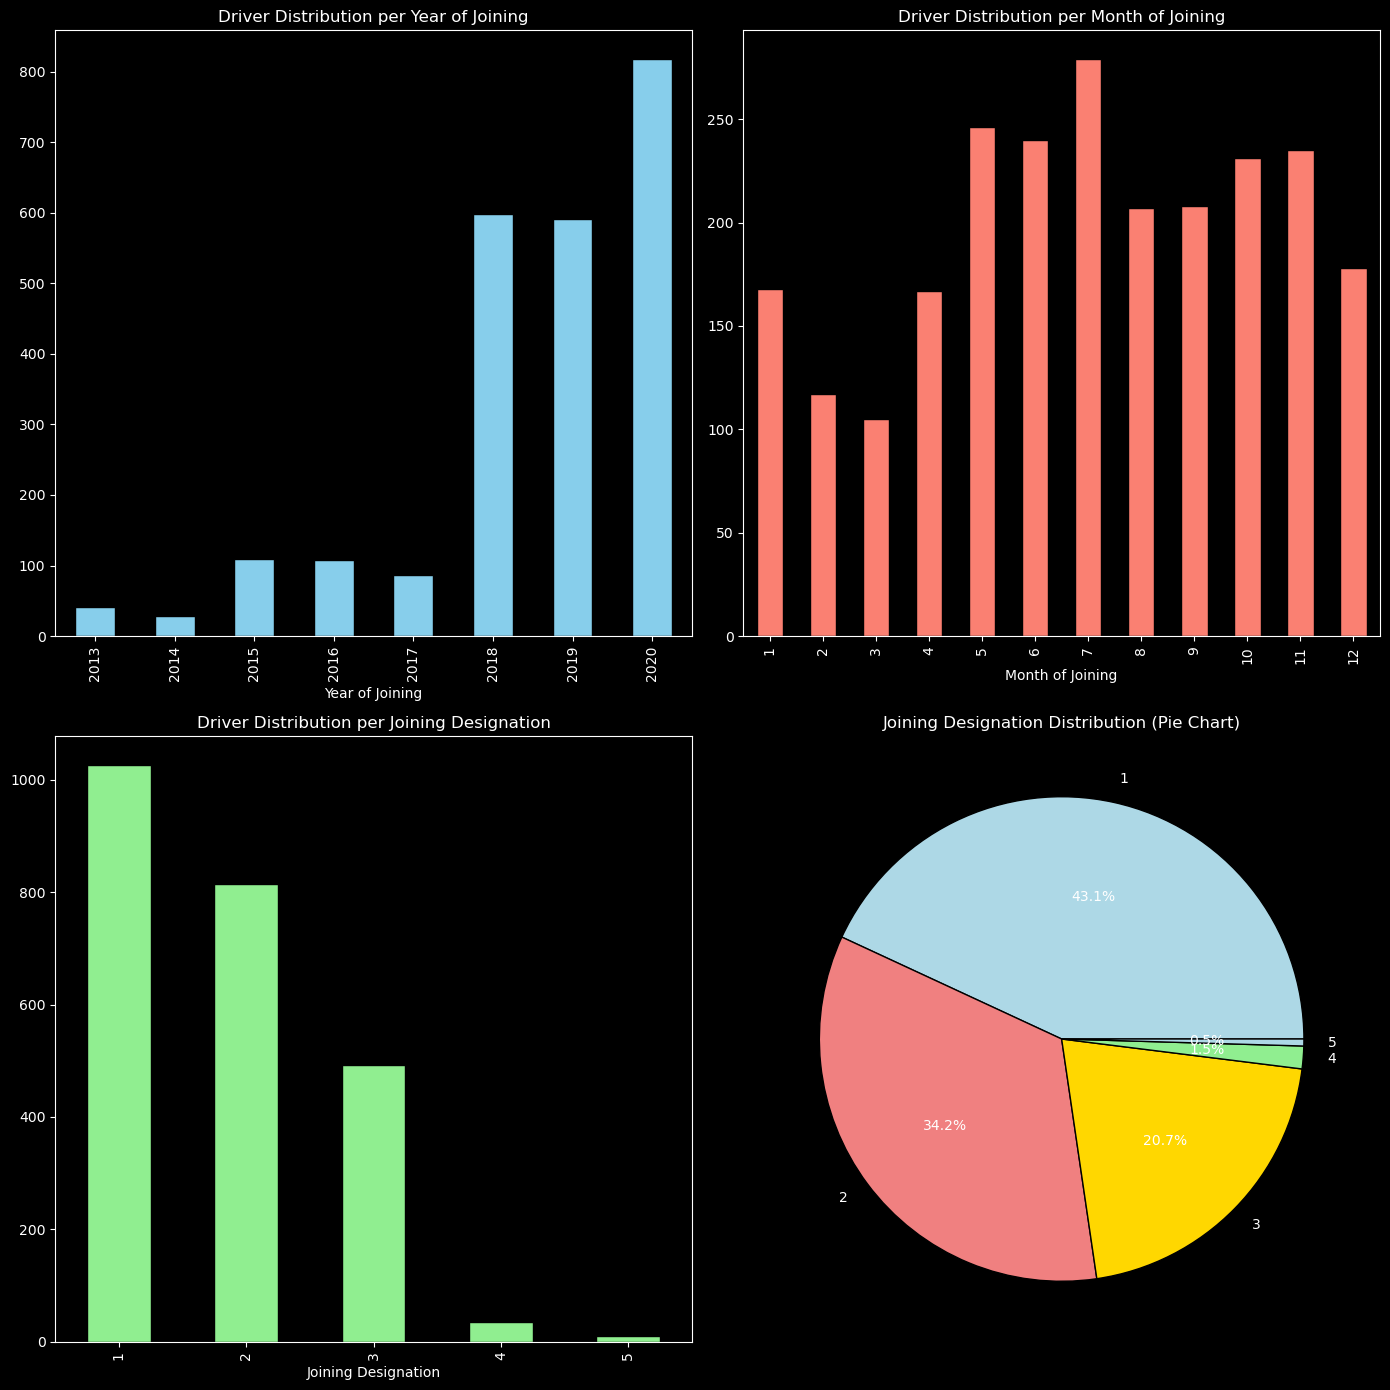

In [41]:
# Ensure Dateofjoining is in datetime format
df['Dateofjoining'] = pd.to_datetime(df['Dateofjoining'])

# Extracting first Date of Joining and Joining Designation per Driver_ID
temp_df_1 = df.groupby('Driver_ID').agg({'Dateofjoining': 'first'}).reset_index()
temp_df_2 = df.groupby('Driver_ID').agg({'Joining Designation': 'first'}).reset_index()
temp_df = pd.merge(temp_df_1, temp_df_2, on='Driver_ID')

# Creating subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 14))

# Plot 1: Year of Joining Distribution
temp_df['Dateofjoining'].dt.year.value_counts().sort_index().plot(
    kind='bar', ax=axs[0, 0], color='skyblue', edgecolor='black'
)
axs[0, 0].set_xlabel('Year of Joining')
axs[0, 0].set_title('Driver Distribution per Year of Joining')

# Plot 2: Month of Joining Distribution
temp_df['Dateofjoining'].dt.month.value_counts().sort_index().plot(
    kind='bar', ax=axs[0, 1], color='salmon', edgecolor='black'
)
axs[0, 1].set_xlabel('Month of Joining')
axs[0, 1].set_title('Driver Distribution per Month of Joining')

# Plot 3: Joining Designation Distribution (Bar Chart)
temp_df['Joining Designation'].value_counts().plot(
    kind='bar', ax=axs[1, 0], color='lightgreen', edgecolor='black'
)
axs[1, 0].set_xlabel('Joining Designation')
axs[1, 0].set_title('Driver Distribution per Joining Designation')

# Plot 4: Joining Designation Distribution (Pie Chart)
temp_df['Joining Designation'].value_counts().plot(
    kind='pie', ax=axs[1, 1], autopct='%.1f%%', colors=['lightblue', 'lightcoral', 'gold', 'lightgreen'],wedgeprops={'edgecolor': 'black'}
)
axs[1, 1].set_title('Joining Designation Distribution (Pie Chart)')
axs[1, 1].set_ylabel('')  # Remove y-label to keep it clean

# Adjust layout for better visualization
plt.tight_layout()
plt.show()


### <span style="color:seagreen"><strong>Insights:</strong></span>
- Maximum number of drivers joined in the year **2020**
- Maximum number of drivers joined in the month of **July**
- Maximum number of drivers, 1026, have a **joining designation of 1**

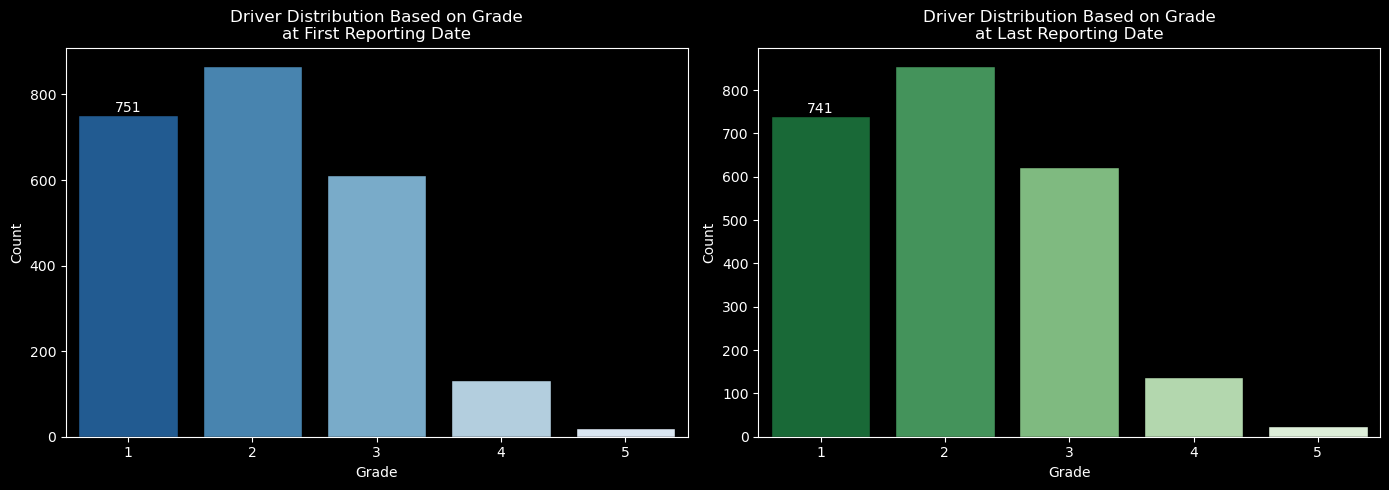

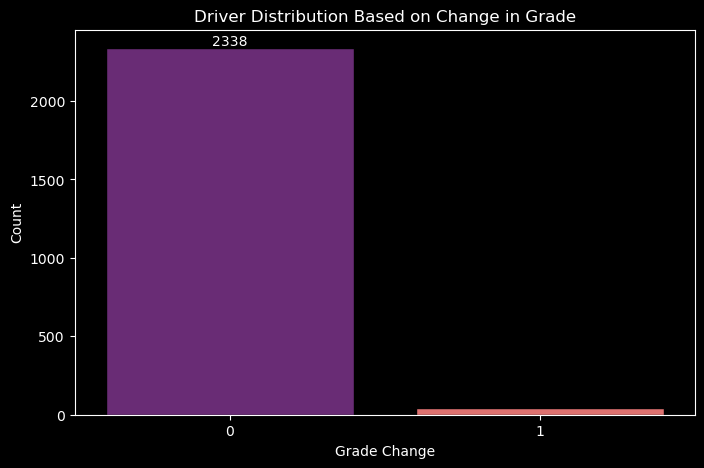

In [43]:
# Prepare the data
temp_df_1 = df.groupby('Driver_ID').agg({'Grade': 'first'}).reset_index()
temp_df_1.rename(columns={'Grade': 'Grade_First'}, inplace=True)

temp_df_2 = df.groupby('Driver_ID').agg({'Grade': 'last'}).reset_index()
temp_df_2.rename(columns={'Grade': 'Grade_Last'}, inplace=True)

# Merge the data
temp_df = pd.merge(temp_df_1, temp_df_2, on='Driver_ID')

# Compute grade change
temp_df['Grade_Change'] = temp_df['Grade_Last'].astype(int) - temp_df['Grade_First'].astype(int)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Seaborn bar plots for first and last grade distributions
sns.barplot(
    x=temp_df['Grade_First'].value_counts().index, 
    y=temp_df['Grade_First'].value_counts().values, 
    ax=axs[0], 
    palette='Blues_r', edgecolor='black'
)
axs[0].set_title('Driver Distribution Based on Grade\nat First Reporting Date')
axs[0].set_xlabel('Grade')
axs[0].set_ylabel('Count')
axs[0].bar_label(axs[0].containers[0])

sns.barplot(
    x=temp_df['Grade_Last'].value_counts().index, 
    y=temp_df['Grade_Last'].value_counts().values, 
    ax=axs[1], 
    palette='Greens_r', edgecolor='black'
)
axs[1].set_title('Driver Distribution Based on Grade\nat Last Reporting Date')
axs[1].set_xlabel('Grade')
axs[1].set_ylabel('Count')
axs[1].bar_label(axs[1].containers[0])

# Show first set of plots
plt.tight_layout()
plt.show()

# Seaborn count plot for Grade Change distribution
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=temp_df, x='Grade_Change', palette='magma', edgecolor='black')
ax.set_title('Driver Distribution Based on Change in Grade')
ax.set_xlabel('Grade Change')
ax.set_ylabel('Count')
ax.bar_label(ax.containers[0])

# Show second plot
plt.show()


### <span style="color:seagreen"><strong>Insights:</strong></span>
- Maximum number of drivers have a **grade of 2** and it doesnt change for the majority of the drivers

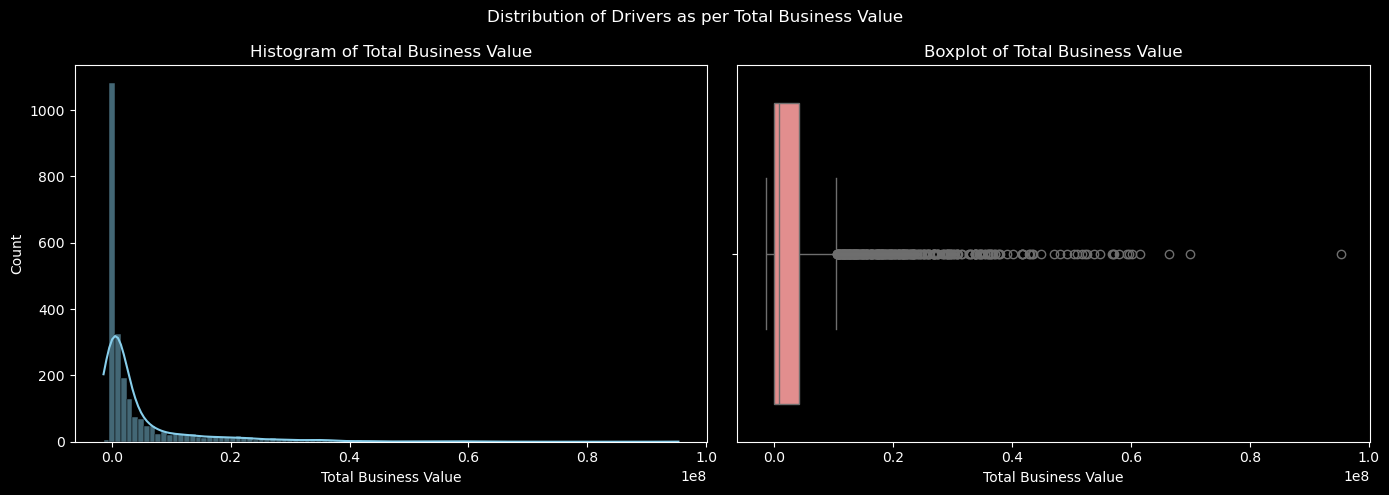

In [45]:
# Prepare the data
temp_df = df.groupby('Driver_ID').agg({'Total Business Value': 'sum'})['Total Business Value']

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Histogram using Seaborn
sns.histplot(temp_df, bins=100, kde=True, ax=axs[0], color='skyblue', edgecolor='black')
axs[0].set_title('Histogram of Total Business Value')
axs[0].set_xlabel('Total Business Value')
axs[0].set_ylabel('Count')

# Boxplot using Seaborn
sns.boxplot(x=temp_df, ax=axs[1], color='lightcoral')
axs[1].set_title('Boxplot of Total Business Value')

# Set a main title
fig.suptitle('Distribution of Drivers as per Total Business Value')

# Show plot
plt.tight_layout()
plt.show()


### <span style="color:seagreen"><strong>Insights:</strong></span>
- It is very evident that **many drivers** have a **total business value of 0** and there are also a few drivers who have a -ve business value
- The distribution is extremely **right skewed**

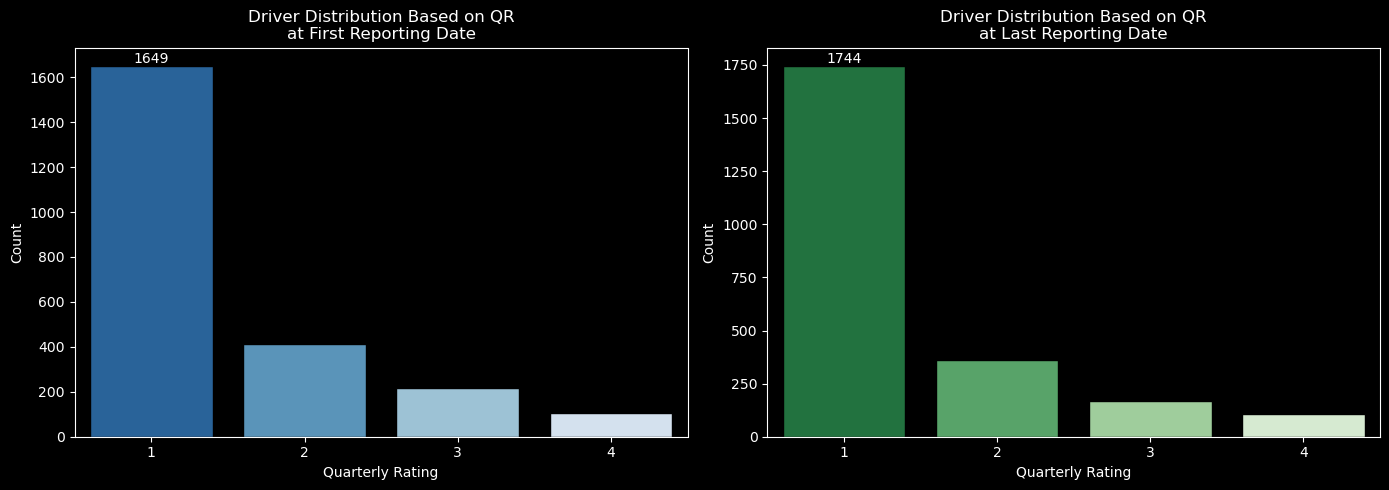

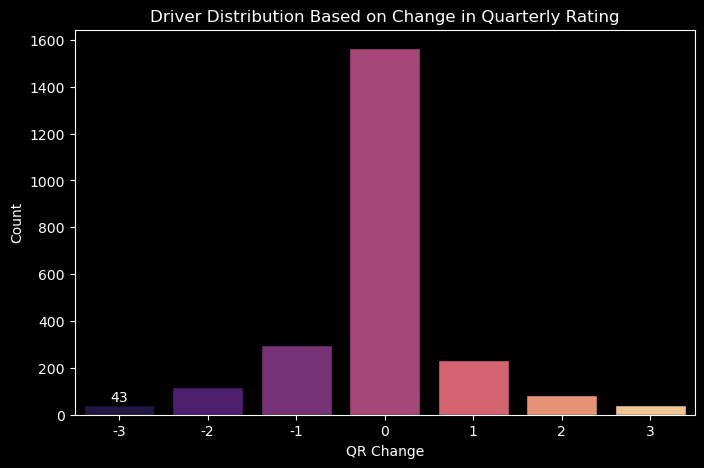

In [47]:
# Prepare the data
temp_df_1 = df.groupby('Driver_ID').agg({'Quarterly Rating': 'first'}).reset_index()
temp_df_1.rename(columns={'Quarterly Rating': 'QR_First'}, inplace=True)

temp_df_2 = df.groupby('Driver_ID').agg({'Quarterly Rating': 'last'}).reset_index()
temp_df_2.rename(columns={'Quarterly Rating': 'QR_Last'}, inplace=True)

# Merge the data
temp_df = pd.merge(temp_df_1, temp_df_2, on='Driver_ID')

# Compute QR change
temp_df['QR_Change'] = temp_df['QR_Last'].astype(int) - temp_df['QR_First'].astype(int)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Seaborn bar plots for first and last QR distributions
sns.barplot(
    x=temp_df['QR_First'].value_counts().index, 
    y=temp_df['QR_First'].value_counts().values, 
    ax=axs[0], 
    palette='Blues_r', edgecolor='black'
)
axs[0].set_title('Driver Distribution Based on QR\nat First Reporting Date')
axs[0].set_xlabel('Quarterly Rating')
axs[0].set_ylabel('Count')
axs[0].bar_label(axs[0].containers[0])

sns.barplot(
    x=temp_df['QR_Last'].value_counts().index, 
    y=temp_df['QR_Last'].value_counts().values, 
    ax=axs[1], 
    palette='Greens_r', edgecolor='black'
)
axs[1].set_title('Driver Distribution Based on QR\nat Last Reporting Date')
axs[1].set_xlabel('Quarterly Rating')
axs[1].set_ylabel('Count')
axs[1].bar_label(axs[1].containers[0])

# Show first set of plots
plt.tight_layout()
plt.show()

# Seaborn count plot for QR Change distribution
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=temp_df, x='QR_Change', palette='magma', edgecolor='black')
ax.set_title('Driver Distribution Based on Change in Quarterly Rating')
ax.set_xlabel('QR Change')
ax.set_ylabel('Count')
ax.bar_label(ax.containers[0])

# Show second plot
plt.show()


### <span style="color:seagreen"><strong>Insights:</strong></span>
- **Majority** of the drivers have a very **low quarterly rating of 1**
- The change in QR plot shows that **majority** of the drivers **don't see a change in their QR** but there are **decent number** of drivers with **positive change in QR** and equally decent number of drivers with **negative change in QR**
- There are **no drivers** with QR of **5**

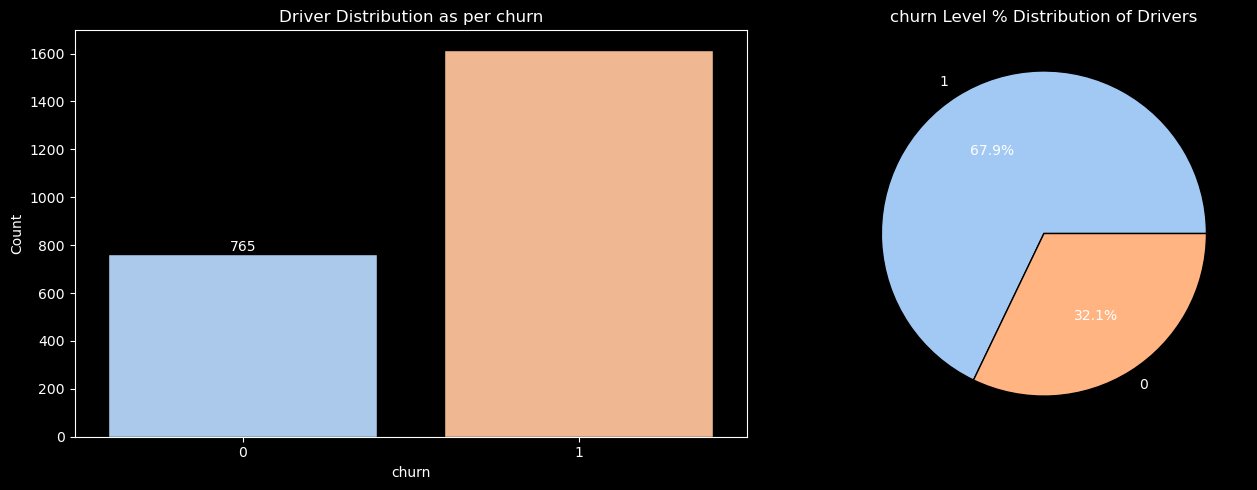

In [49]:
# Prepare the data
temp_df = df.groupby('Driver_ID').agg({'churn': 'first'})

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot using Seaborn
sns.barplot(
    x=temp_df['churn'].value_counts().index, 
    y=temp_df['churn'].value_counts().values, 
    ax=axs[0], 
    palette='pastel', edgecolor='black'
)
axs[0].set_xlabel('churn')
axs[0].set_ylabel('Count')
axs[0].set_title('Driver Distribution as per churn')
axs[0].bar_label(axs[0].containers[0])

# Pie chart using Matplotlib (since Seaborn does not support pie charts)
temp_df['churn'].value_counts().plot(
    kind='pie', 
    ax=axs[1], 
    autopct='%.1f%%', 
    colors=sns.color_palette('pastel'),
    wedgeprops={'edgecolor': 'black'}
)

# Adjust pie chart labels
axs[1].set_ylabel('')  # Remove y-axis label
axs[1].set_title('churn Level % Distribution of Drivers')

# Show plot
plt.tight_layout()
plt.show()


### <span style="color:seagreen"><strong>Insights:</strong></span>
- **1616** drivers have **churned**, which is around **68%**

### Bivariate analysis

In [52]:
driver_df = df.groupby('Driver_ID').agg({
    'ReportingMonthYear' : len,
    'Age' : 'last',
    'Gender' : 'first',
    'City' : 'first',
    'Education_Level' : 'first',
    'Income' : 'last',
    'Dateofjoining' : 'first',
    'LastWorkingDate' : 'last',
    'Joining Designation' : 'first',
    'Grade' : 'last',
    'Total Business Value' : 'sum',
    'Quarterly Rating' : 'last',
    'churn':'last'
}).reset_index()
driver_df.rename(columns={'ReportingMonthYear': 'Months of Service'}, inplace=True)
driver_df.head(10)

,Driver_ID,Months of Service,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating,churn
0,1,3,28.0,Male,C23,Graduate,57387,2018-12-24,2019-11-03,1,1,1715580,2,1
1,2,2,31.0,Male,C7,Graduate,67016,2020-06-11,NaT,2,2,0,1,0
2,4,5,43.0,Male,C13,Graduate,65603,2019-07-12,2020-04-27,2,2,350000,1,1
3,5,3,29.0,Male,C9,10+,46368,2019-09-01,2019-07-03,1,1,120360,1,1
4,6,5,31.0,Female,C11,12+,78728,2020-07-31,NaT,3,3,1265000,2,0
5,8,3,34.0,Male,C2,10+,70656,2020-09-19,2020-11-15,3,3,0,1,1
6,11,1,28.0,Female,C19,Graduate,42172,2020-07-12,NaT,1,1,0,1,0
7,12,6,35.0,Male,C23,Graduate,28116,2019-06-29,2019-12-21,1,1,2607180,1,1
8,13,23,31.0,Male,C19,Graduate,119227,2015-05-28,2020-11-25,1,4,10213040,1,1
9,14,3,39.0,Female,C26,10+,19734,2020-10-16,NaT,3,3,0,1,0


In [53]:
drivers_with_2_year_service = driver_df[driver_df['Months of Service'] == 24]['Driver_ID'].reset_index(drop=True)

In [54]:
def calculate_change(df, column_name):
    temp_df_1 = df.groupby('Driver_ID').agg({column_name:'first'}).reset_index()
    first_column_name = column_name+'_First'
    temp_df_1.rename(columns = {column_name:first_column_name}, inplace=True)
    temp_df_2 = df.groupby('Driver_ID').agg({column_name:'last'}).reset_index()
    last_column_name = column_name+'_Last'
    temp_df_2.rename(columns = {column_name:last_column_name}, inplace=True)
    temp_df = pd.merge(temp_df_1, temp_df_2, on='Driver_ID')
    temp_df[column_name+'_Change'] = temp_df[last_column_name].astype('int') - temp_df[first_column_name].astype('int')
    temp_df.drop(columns=[first_column_name, last_column_name], inplace=True)
    return temp_df

In [55]:
column_name = 'Income'
temp_df1 = calculate_change(df, 'Income')
driver_df = pd.merge(driver_df, temp_df1, on='Driver_ID')
temp_df2 = calculate_change(df, 'Grade')
driver_df = pd.merge(driver_df, temp_df2, on='Driver_ID')
temp_df3 = calculate_change(df, 'Quarterly Rating')
driver_df = pd.merge(driver_df, temp_df3, on='Driver_ID')
driver_df['Quarterly Rating Improved'] = driver_df['Quarterly Rating_Change'].apply(lambda x: 1 if x>0 else 0)
driver_df.head()

,Driver_ID,Months of Service,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating,churn,Income_Change,Grade_Change,Quarterly Rating_Change,Quarterly Rating Improved
0,1,3,28.0,Male,C23,Graduate,57387,2018-12-24,2019-11-03,1,1,1715580,2,1,0,0,0,0
1,2,2,31.0,Male,C7,Graduate,67016,2020-06-11,NaT,2,2,0,1,0,0,0,0,0
2,4,5,43.0,Male,C13,Graduate,65603,2019-07-12,2020-04-27,2,2,350000,1,1,0,0,0,0
3,5,3,29.0,Male,C9,10+,46368,2019-09-01,2019-07-03,1,1,120360,1,1,0,0,0,0
4,6,5,31.0,Female,C11,12+,78728,2020-07-31,NaT,3,3,1265000,2,0,0,0,1,1


In [56]:
driver_df['Income_Raise'] = driver_df['Income_Change'].apply(lambda x: 1 if x>0 else 0)

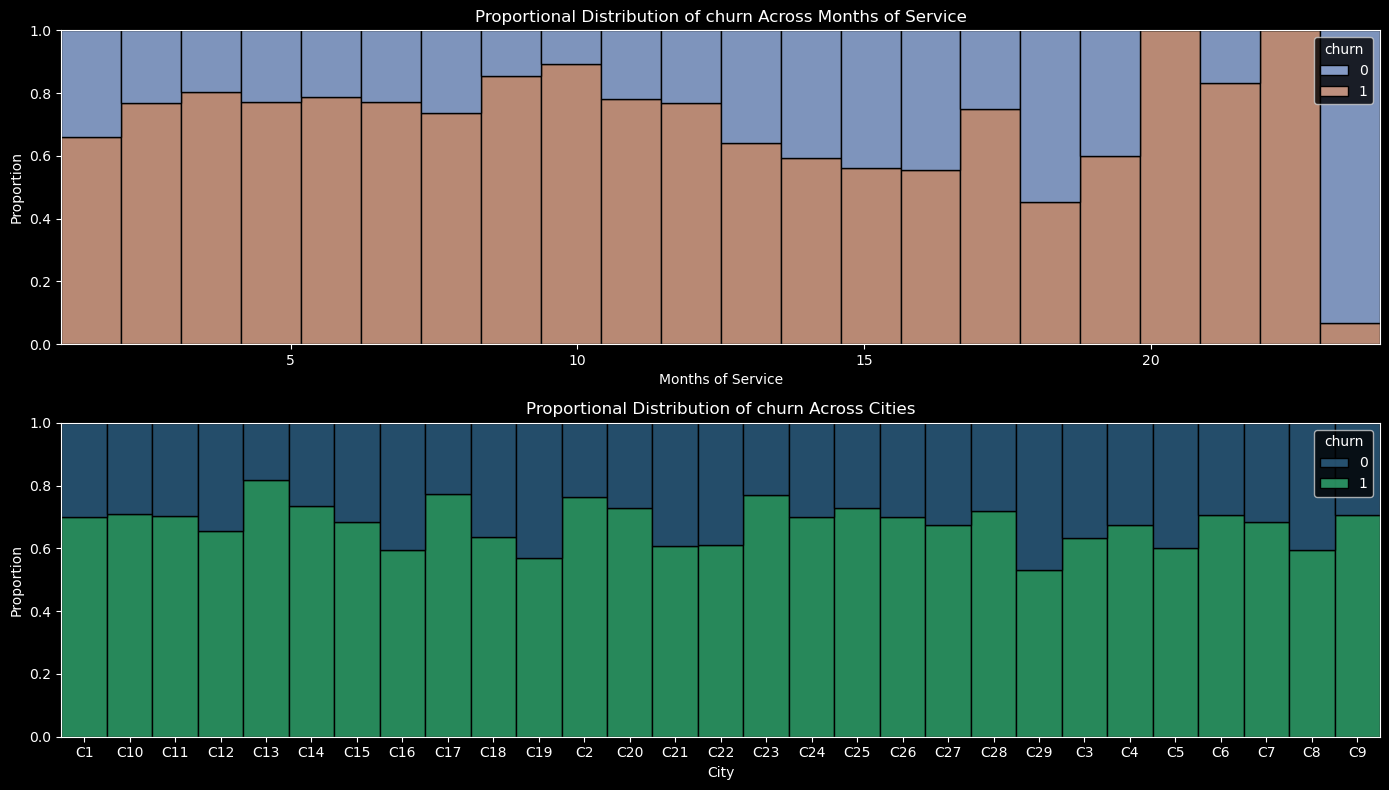

In [57]:
# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(14, 8))

# Histogram for 'Months of Service' with proportional distribution by 'churn'
sns.histplot(
    data=driver_df, 
    x='Months of Service', 
    hue='churn', 
    stat="proportion", 
    multiple="fill", 
    ax=axs[0], 
    palette='coolwarm', edgecolor='black'
)
axs[0].set_title('Proportional Distribution of churn Across Months of Service')
axs[0].set_xlabel('Months of Service')
axs[0].set_ylabel('Proportion')

# Histogram for 'City' with proportional distribution by 'churn'
sns.histplot(
    data=driver_df, 
    x='City', 
    hue='churn', 
    stat="proportion", 
    multiple="fill", 
    ax=axs[1], 
    palette='viridis', edgecolor='black'
)
axs[1].set_title('Proportional Distribution of churn Across Cities')
axs[1].set_xlabel('City')
axs[1].set_ylabel('Proportion')

# Adjust layout for better spacing
plt.tight_layout()

# Show plot
plt.show()


### <span style="color:seagreen"><strong>Insights:</strong></span>
- The **churn** rate is generally **higher** in drivers with **less months of service** and low in drivers with longer months of service with exception for 21, 22 and 23 months of service where the churn rates seems to be very high
- The city **C13** has the **highest churn rate** and city **C29** has the **lowest churn rate**

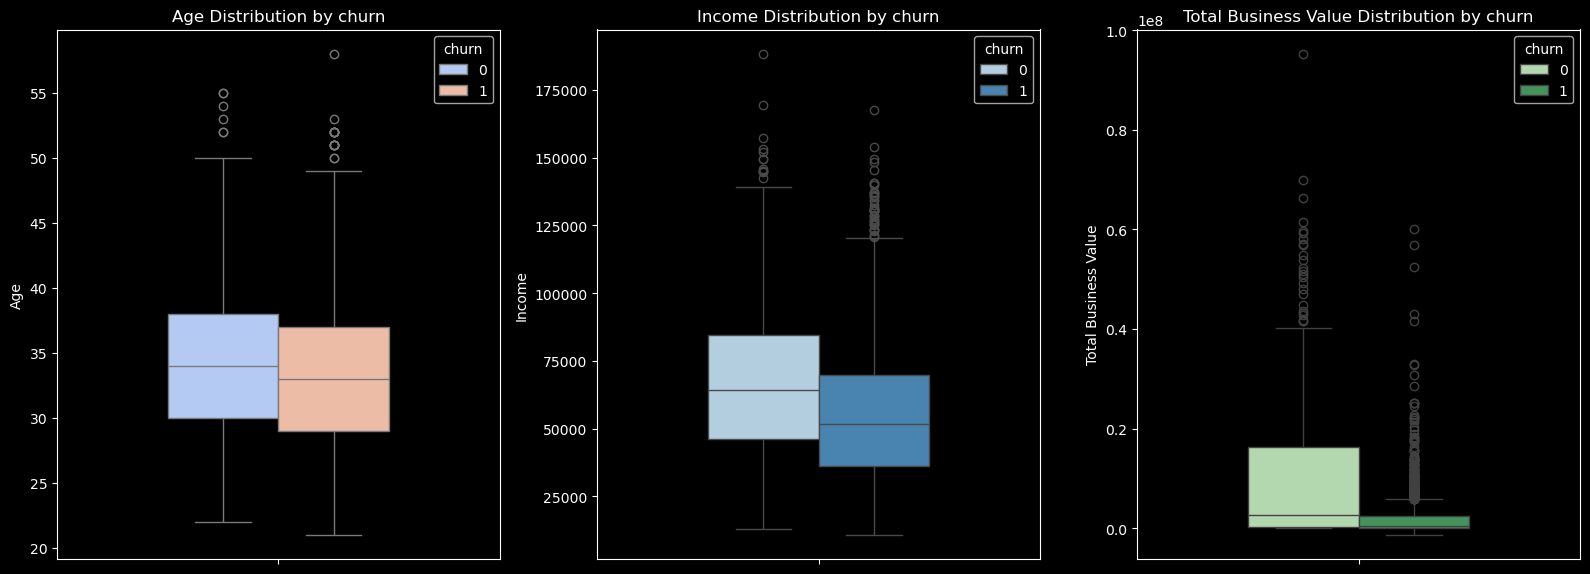

In [59]:
# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(16, 6))

# Boxplot for Age
sns.boxplot(
    data=driver_df, 
    y='Age', 
    hue='churn', 
    ax=axs[0], 
    width=0.5, 
    palette='coolwarm'
)
axs[0].set_title('Age Distribution by churn')
axs[0].set_ylabel('Age')

# Boxplot for Income
sns.boxplot(
    data=driver_df, 
    y='Income', 
    hue='churn', 
    ax=axs[1], 
    width=0.5, 
    palette='Blues'
)
axs[1].set_title('Income Distribution by churn')
axs[1].set_ylabel('Income')

# Boxplot for Total Business Value
sns.boxplot(
    data=driver_df, 
    y='Total Business Value', 
    hue='churn', 
    ax=axs[2], 
    width=0.5, 
    palette='Greens'
)
axs[2].set_title('Total Business Value Distribution by churn')
axs[2].set_ylabel('Total Business Value')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


### <span style="color:seagreen"><strong>Insights:</strong></span>
- The **median age** of drivers who have **churned** is **slighly lesser** than that of the drivers who have not churned
- The **median income** of drivers who have **churned** is **lesser** than that of the drivers who have not churned
- The **median Total Bussiness Value** of drivers who have **churned** is **lesser** than that of the drivers who have not churned
- The drivers who have **churned** also had **-ve Total Bussiness Value**

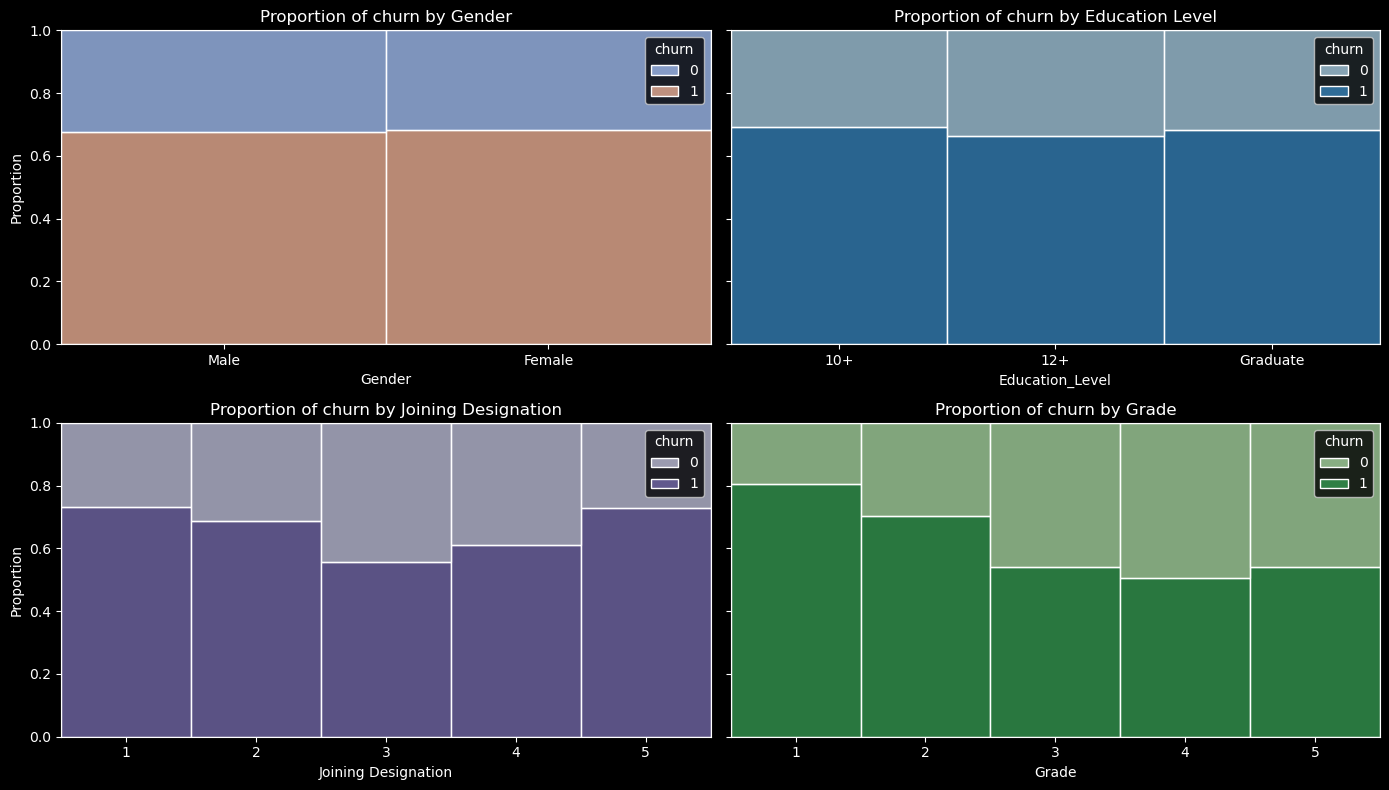

In [61]:
# Create subplots with shared y-axis for better comparison
fig, axs = plt.subplots(2, 2, figsize=(14, 8), sharey=True)

# Gender Distribution
sns.histplot(
    data=driver_df, 
    x='Gender', 
    hue='churn', 
    stat="proportion", 
    multiple="fill", 
    ax=axs[0, 0], 
    palette='coolwarm'
)
axs[0, 0].set_title('Proportion of churn by Gender')

# Education Level Distribution
sns.histplot(
    data=driver_df, 
    x='Education_Level', 
    hue='churn', 
    stat='proportion', 
    multiple='fill', 
    ax=axs[0, 1], 
    palette='Blues'
)
axs[0, 1].set_title('Proportion of churn by Education Level')

# Joining Designation Distribution
sns.histplot(
    data=driver_df, 
    x='Joining Designation', 
    hue='churn', 
    stat='proportion', 
    multiple='fill', 
    ax=axs[1, 0], 
    palette='Purples'
)
axs[1, 0].set_title('Proportion of churn by Joining Designation')

# Grade Distribution
sns.histplot(
    data=driver_df, 
    x='Grade', 
    hue='churn', 
    stat='proportion', 
    multiple='fill', 
    ax=axs[1, 1], 
    palette='Greens'
)
axs[1, 1].set_title('Proportion of churn by Grade')

# Adjust layout for better spacing
plt.tight_layout()

# Show plot
plt.show()


### <span style="color:seagreen"><strong>Insights:</strong></span>
- The **churn** rate is **almost equal** in both **male and female** drivers
- The **churn** rate is **almost equal** in **10+ and Graduates** and slighly **lower** in **12+**
- The **churn** rate is **less** for **joining designation 3**
- The **churn** rate is **less** for **higher grades**

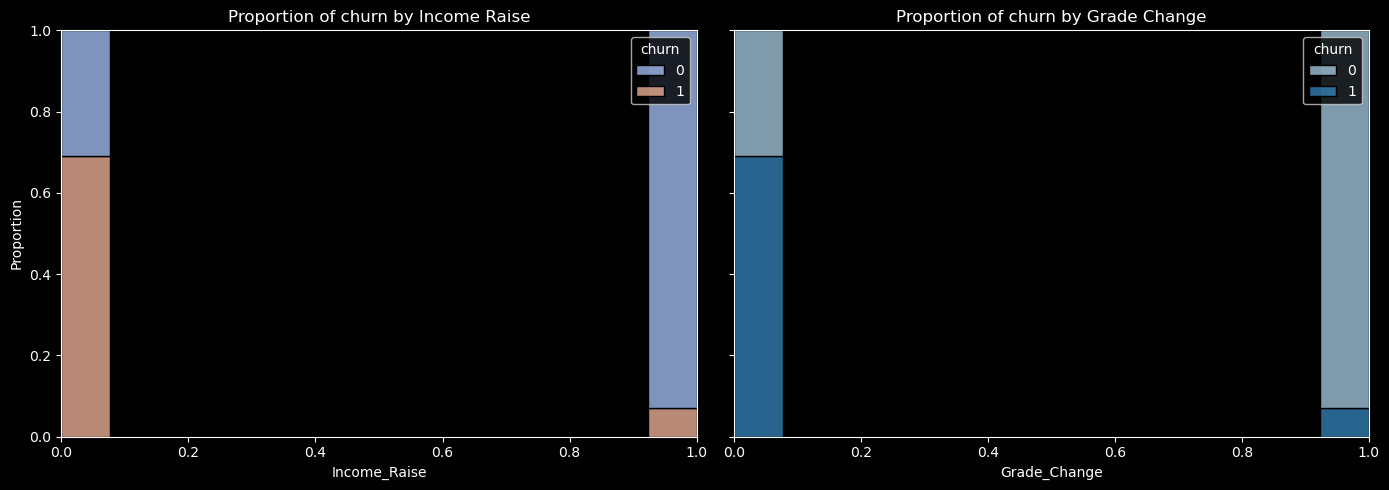

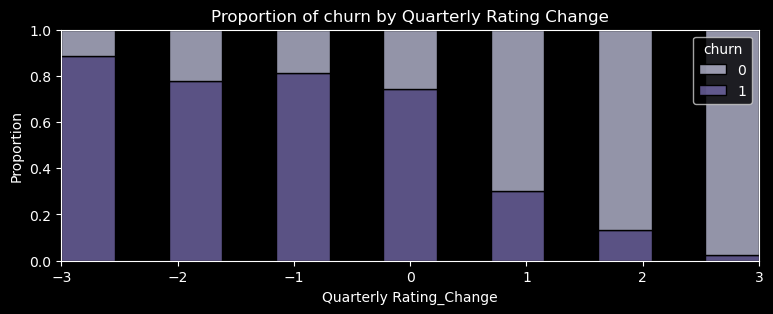

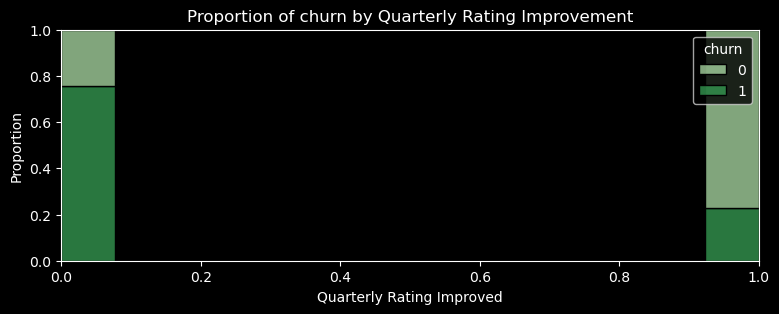

In [63]:
# Create subplots for Income Raise and Grade Change
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

sns.histplot(
    data=driver_df, 
    x='Income_Raise', 
    hue='churn', 
    stat='proportion', 
    multiple='fill', 
    ax=axs[0], 
    palette='coolwarm', edgecolor='black'
)
axs[0].set_title('Proportion of churn by Income Raise')

sns.histplot(
    data=driver_df, 
    x='Grade_Change', 
    hue='churn', 
    stat='proportion', 
    multiple='fill', 
    ax=axs[1], 
    palette='Blues', edgecolor='black'
)
axs[1].set_title('Proportion of churn by Grade Change')

plt.tight_layout()
plt.show()

# Plot for Quarterly Rating Change
plt.figure(figsize=(9, 3))
sns.histplot(
    data=driver_df, 
    x='Quarterly Rating_Change', 
    hue='churn', 
    stat='proportion', 
    multiple='fill', 
    palette='Purples', edgecolor='black'
)
plt.title('Proportion of churn by Quarterly Rating Change')
plt.show()

# Plot for Quarterly Rating Improvement
plt.figure(figsize=(9, 3))
sns.histplot(
    data=driver_df, 
    x='Quarterly Rating Improved', 
    hue='churn', 
    stat='proportion', 
    multiple='fill', 
    palette='Greens', edgecolor='black'
)
plt.title('Proportion of churn by Quarterly Rating Improvement')
plt.show()


### <span style="color:seagreen"><strong>Insights:</strong></span>
- The **churn rate** is **very less** in drivers whose **income has raised**
- The **churn rate** is **very less** in drivers whose **grade has raised**
- The **churn rate** is **very less** in drivers whose **Quarterly rating has increased**

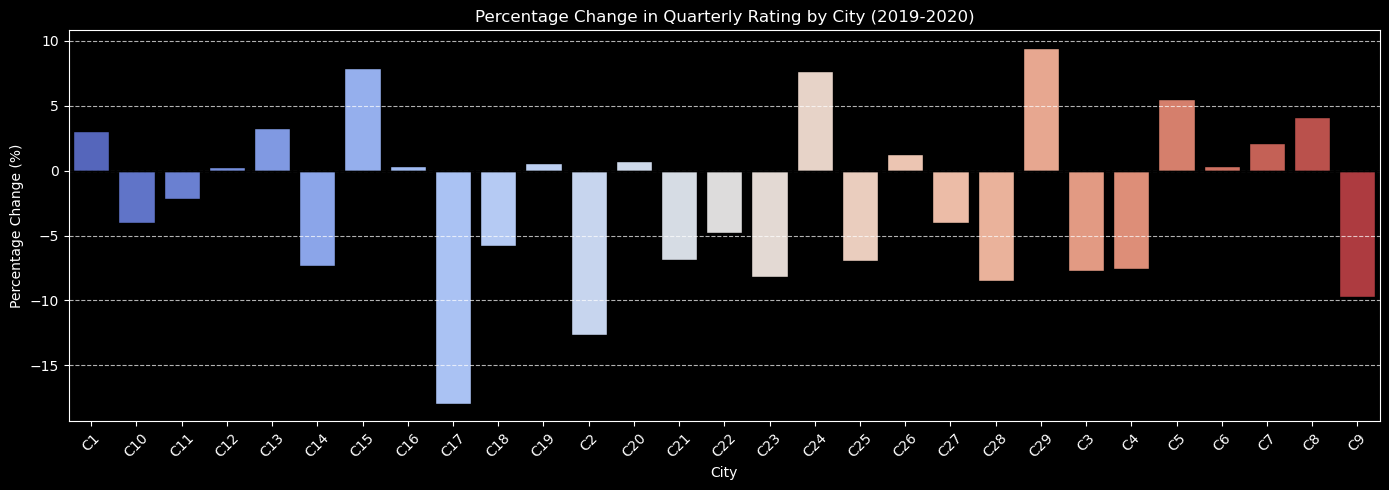

In [65]:
# Group by City and ReportingYear, then compute mean Quarterly Rating
temp_df = df.groupby(['City', 'ReportingYear']).agg({'Quarterly Rating': 'mean'}).reset_index()

# Pivot table to have years as columns
temp_df1 = temp_df.pivot(index='City', columns='ReportingYear', values='Quarterly Rating').reset_index()

# Rename columns for clarity
temp_df1.rename(columns={2019: '2019', 2020: '2020'}, inplace=True)

# Calculate percentage change from 2019 to 2020
temp_df1['%change'] = (((temp_df1['2020'] - temp_df1['2019']) / temp_df1['2019']) * 100).round(2)

# Create the barplot
plt.figure(figsize=(14, 5))
sns.barplot(data=temp_df1, x='City', y='%change', palette='coolwarm', edgecolor='black')

# Enhance readability
plt.axhline(0, color='black', linewidth=1)  # Add a reference line at 0%
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.title('Percentage Change in Quarterly Rating by City (2019-2020)')
plt.ylabel('Percentage Change (%)')
plt.xlabel('City')

plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines for better readability
plt.tight_layout()
plt.show()


### <span style="color:seagreen"><strong>Insights:</strong></span>
- The city **C29** shows  most improvement in Quarterly Rating in 2020 compared to 2019

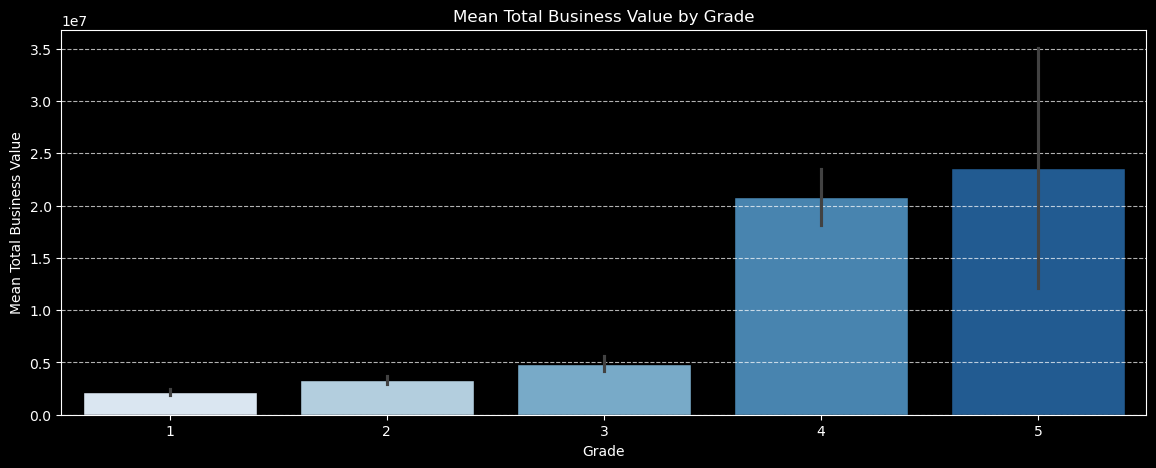

Mean of Total Business Value of drivers with Grade 5: 565760460


In [67]:
# Create a bar plot for mean Total Business Value per Grade
plt.figure(figsize=(14, 5))
sns.barplot(data=driver_df, x='Grade', y='Total Business Value', estimator='mean', palette='Blues', edgecolor='black')

# Enhance visualization
plt.title('Mean Total Business Value by Grade')
plt.xlabel('Grade')
plt.ylabel('Mean Total Business Value')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Compute and print the sum for Grade 5
grade_5_total_business_value = driver_df[driver_df['Grade'] == 5]['Total Business Value'].sum()
print(f"Mean of Total Business Value of drivers with Grade 5: {grade_5_total_business_value}")


### <span style="color:seagreen"><strong>Insights:</strong></span>
- The mean of Total Business Value of drivers with grade 5 is higher than those with other grades

In [69]:
def convert_to_year_quarter(x):
    year = str(x.year)
    month = x.month
    if(month >=1 and month <=3):
        return year+'-Q1'
    elif(month >=4 and month <=6):
        return year+'-Q2'
    elif(month >=7 and month <=9):
        return year+'-Q3'
    else:
        return year+'-Q4'

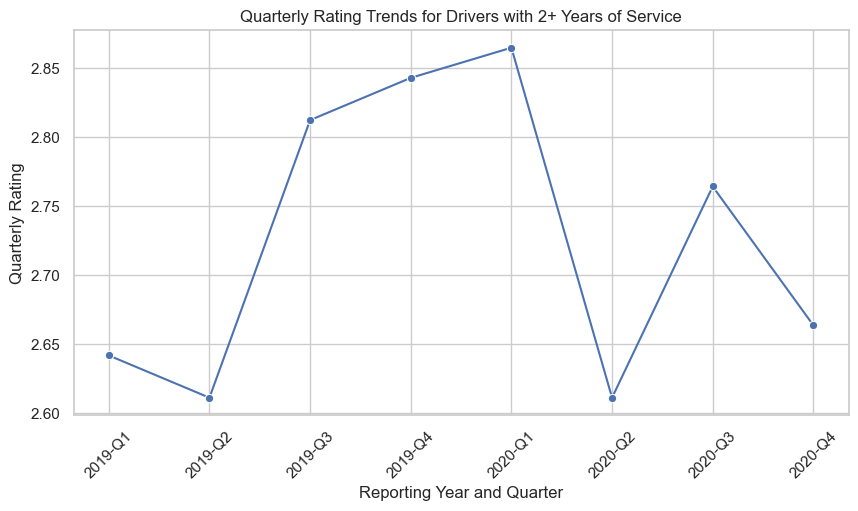

In [70]:
# Create a copy of the DataFrame
temp_df = df.copy()
temp_df['ReportingYearQuarter'] = temp_df['ReportingMonthYear'].apply(convert_to_year_quarter)

# Filter drivers with at least 2 years of service and aggregate data
temp_driver_full_service_df = (
    temp_df[temp_df['Driver_ID'].isin(drivers_with_2_year_service)]
    .groupby(['Driver_ID', 'ReportingYearQuarter'])
    .agg({'Quarterly Rating': 'last', 'Total Business Value': 'sum'})
    .reset_index()
)

# Ensure the x-axis is ordered correctly
temp_driver_full_service_df['ReportingYearQuarter'] = pd.Categorical(
    temp_driver_full_service_df['ReportingYearQuarter'],
    categories=sorted(temp_driver_full_service_df['ReportingYearQuarter'].unique()),
    ordered=True
)

# Set Seaborn style
sns.set_theme(style="whitegrid")

# Create the line plot
plt.figure(figsize=(10, 5))
sns.lineplot(
    data=temp_driver_full_service_df, 
    x='ReportingYearQuarter', 
    y='Quarterly Rating',
    estimator='mean',  # Optional: Aggregate multiple drivers per quarter
    ci=None,  # Remove confidence interval if unnecessary
    marker='o'  # Add markers for better readability
)

# Improve readability
plt.xticks(rotation=45)
plt.xlabel('Reporting Year and Quarter')
plt.ylabel('Quarterly Rating')
plt.title('Quarterly Rating Trends for Drivers with 2+ Years of Service')

plt.show()


### <span style="color:seagreen"><strong>Insights:</strong></span>
- There is a dip in the quarterly rating in Q2 and then it increases in Q3.
- This pattern can be osberved for both the years

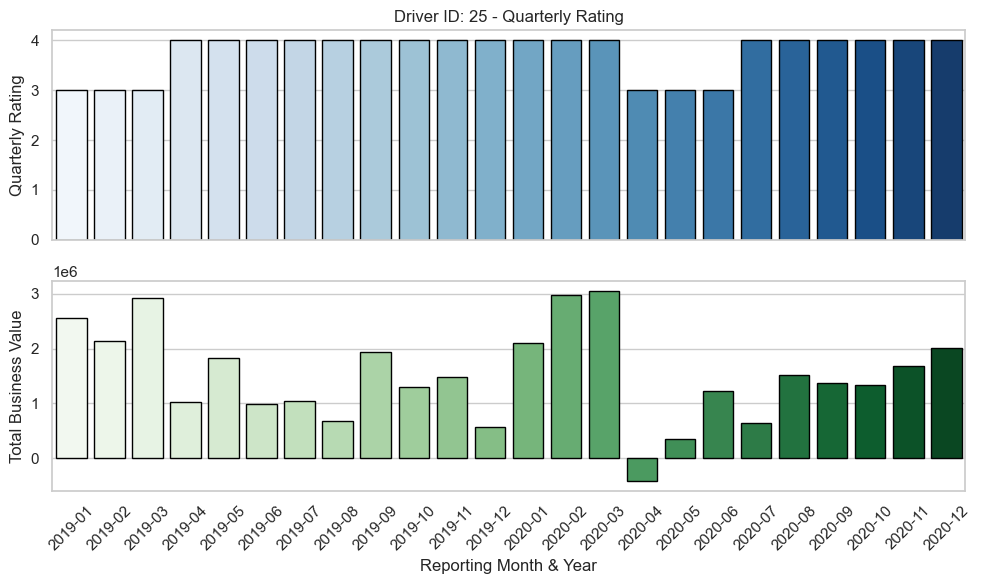

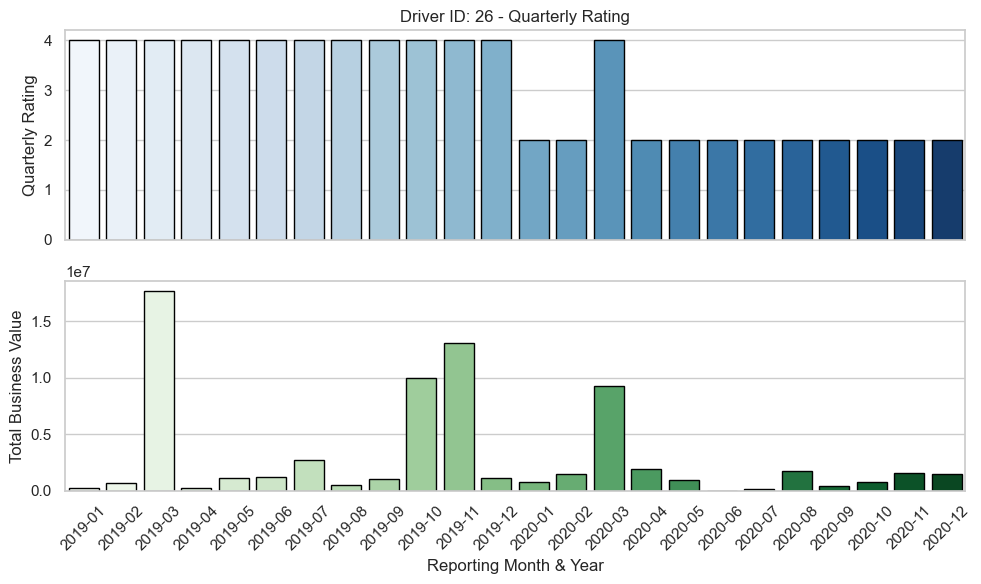

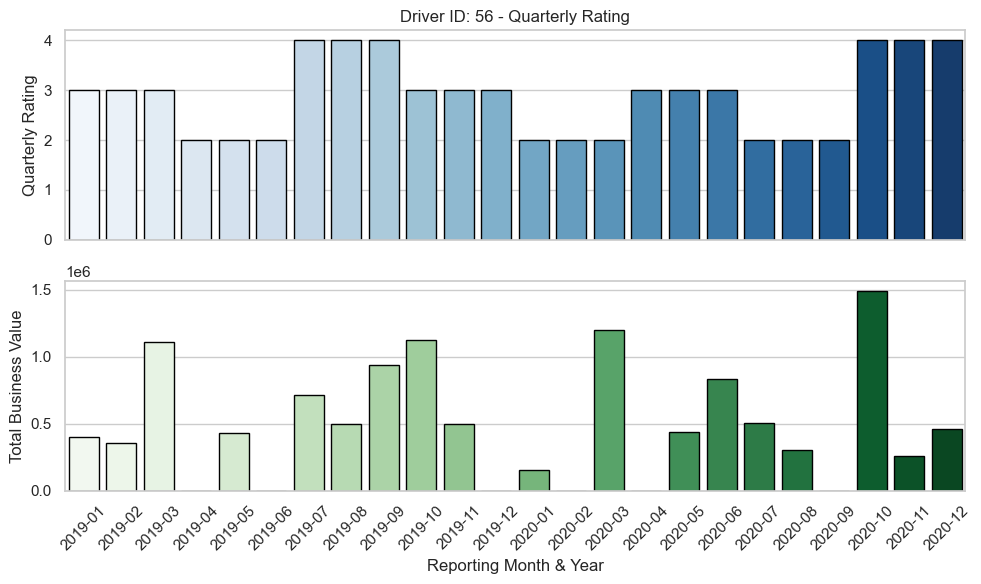

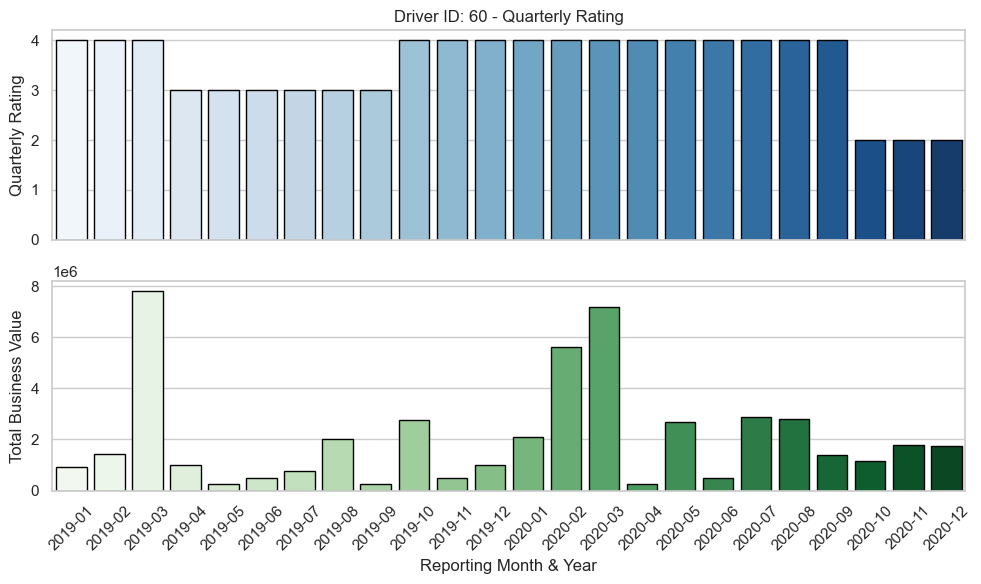

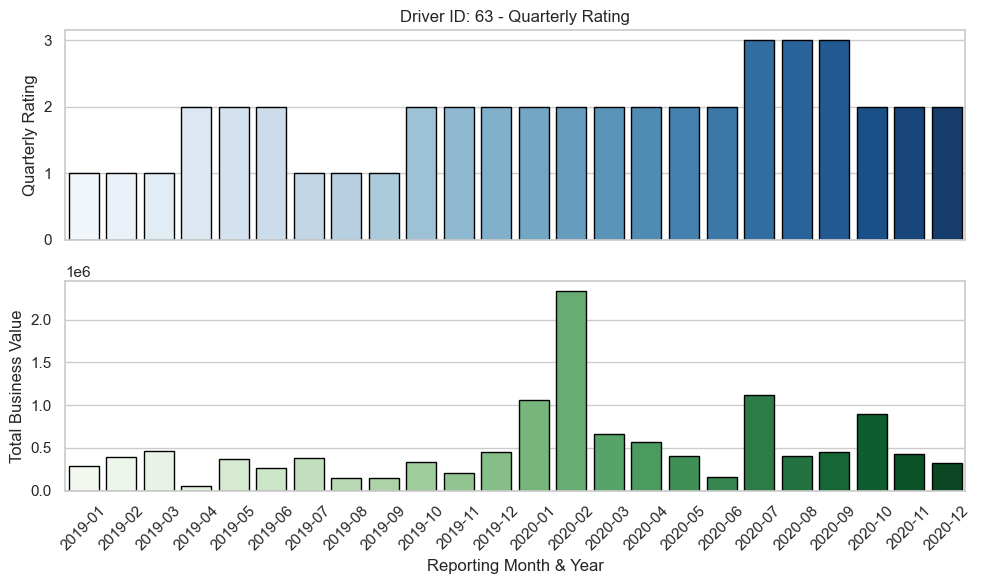

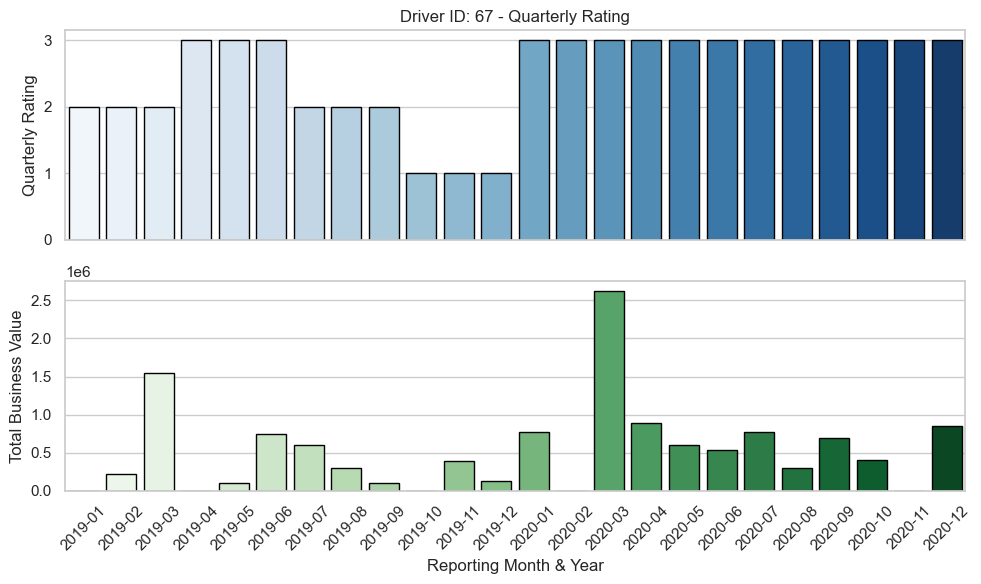

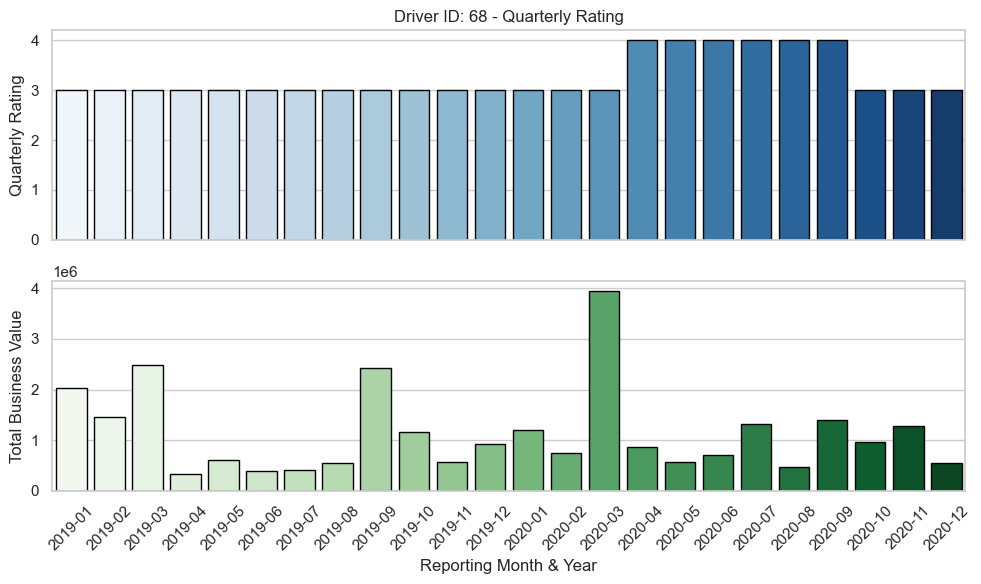

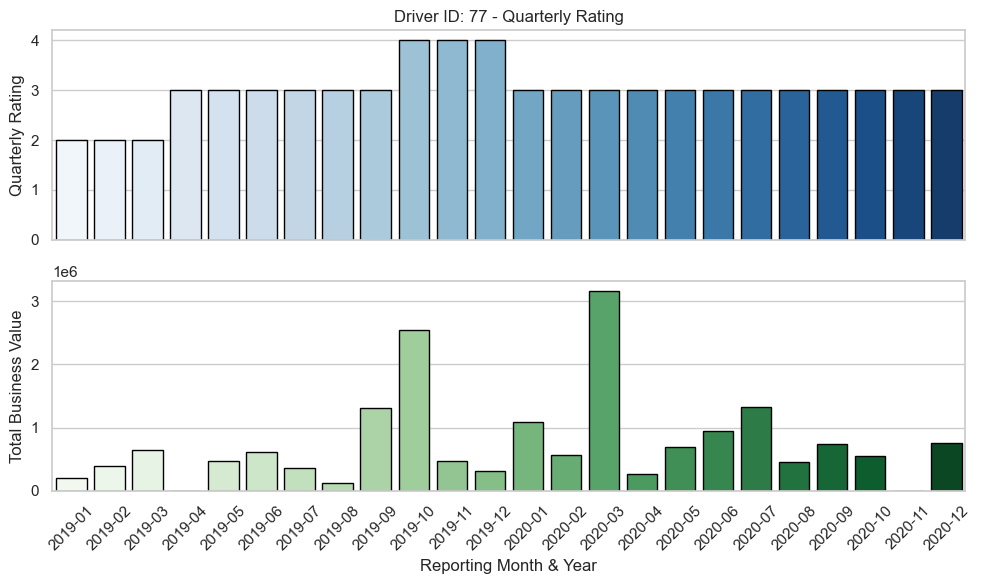

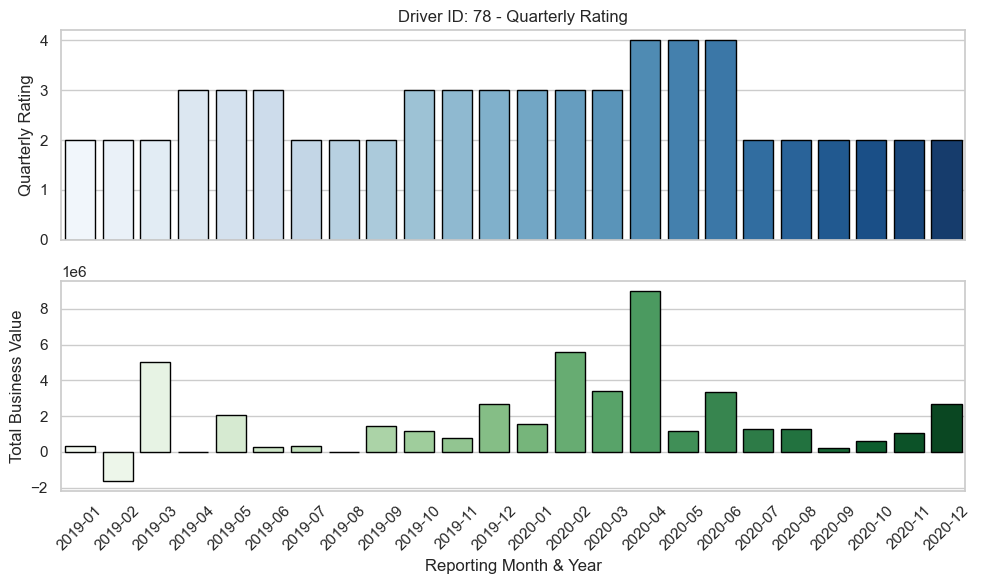

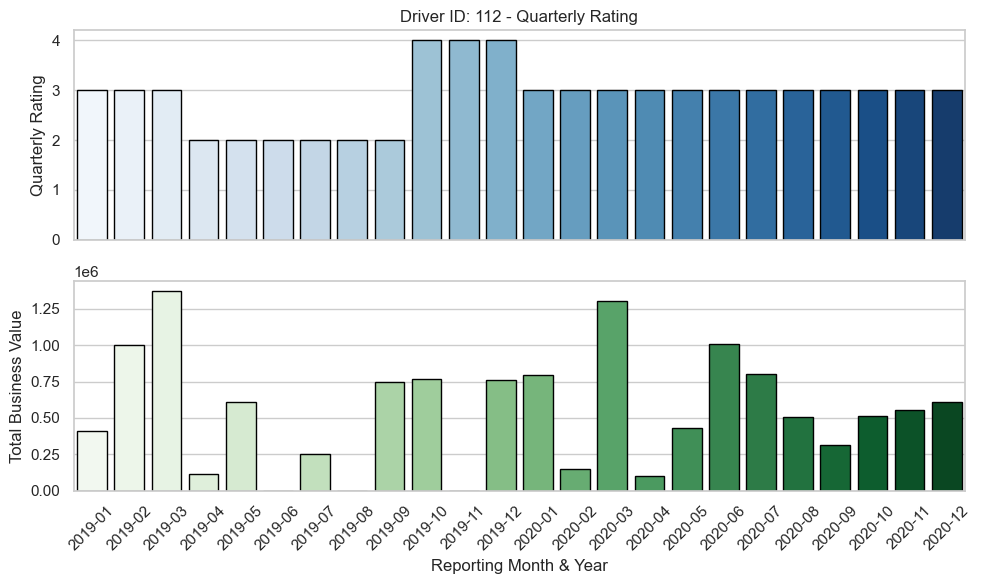

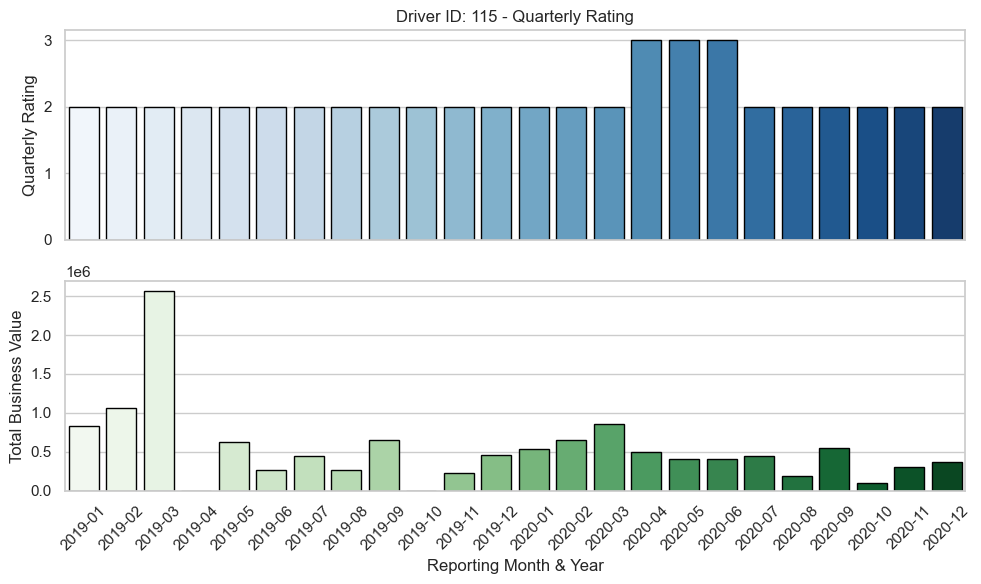

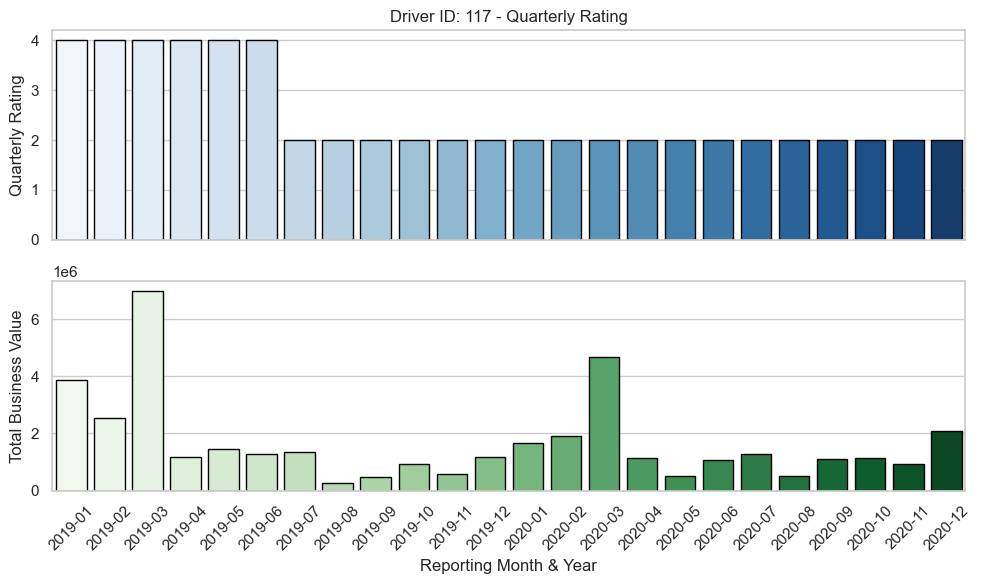

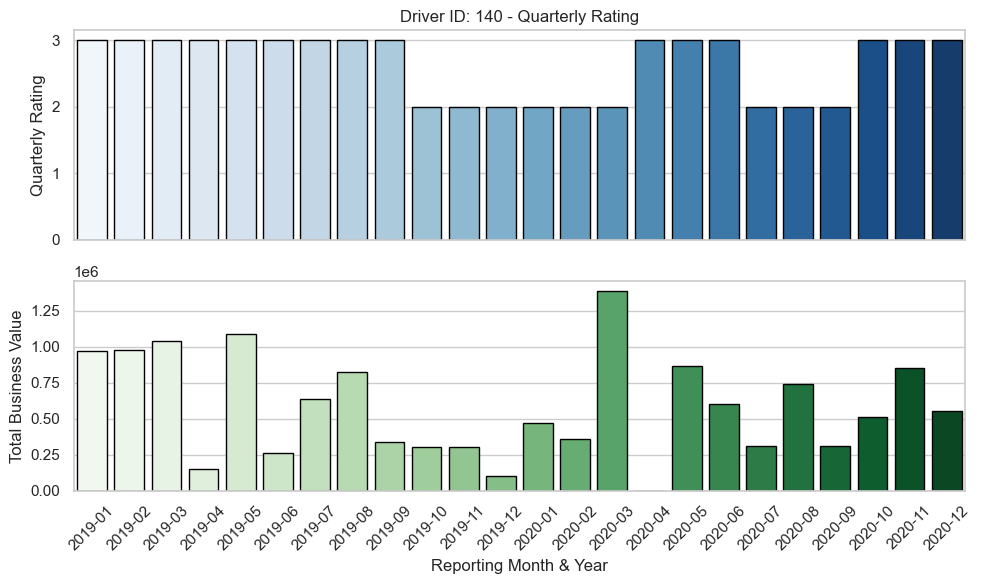

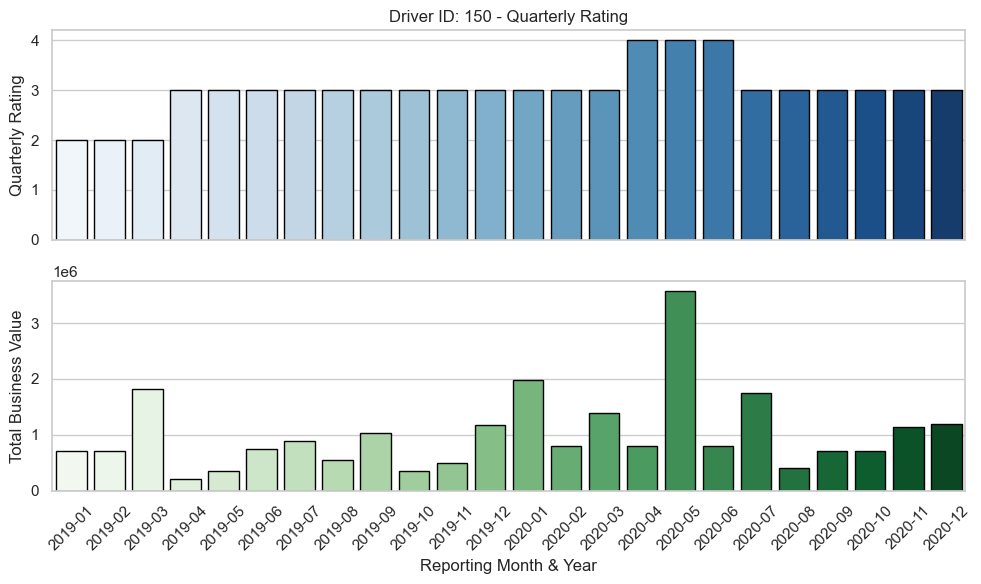

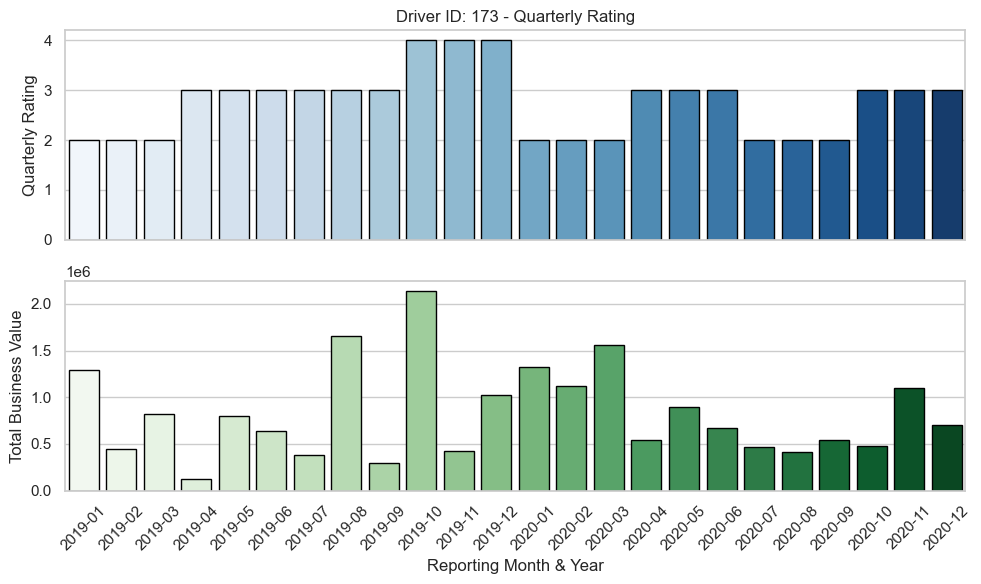

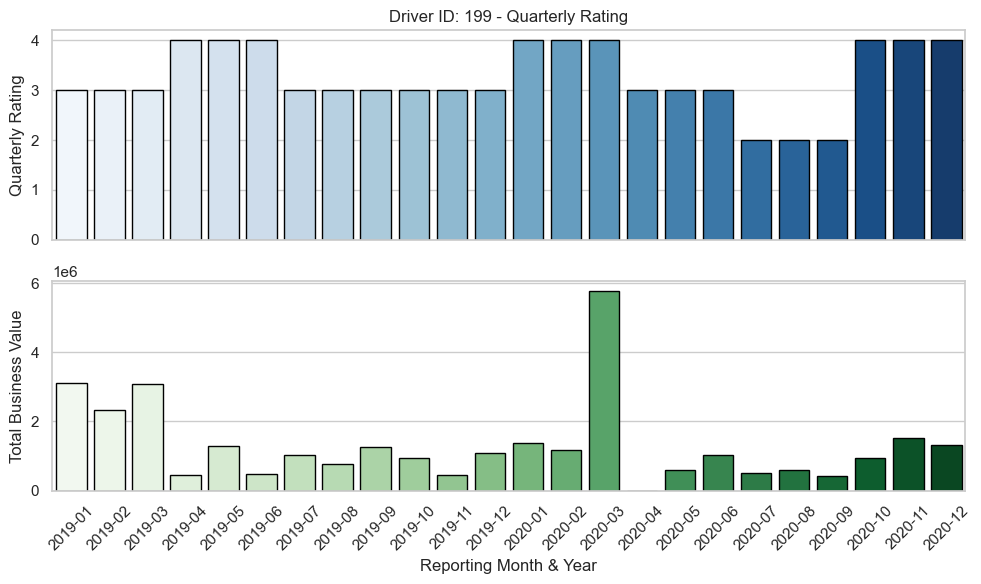

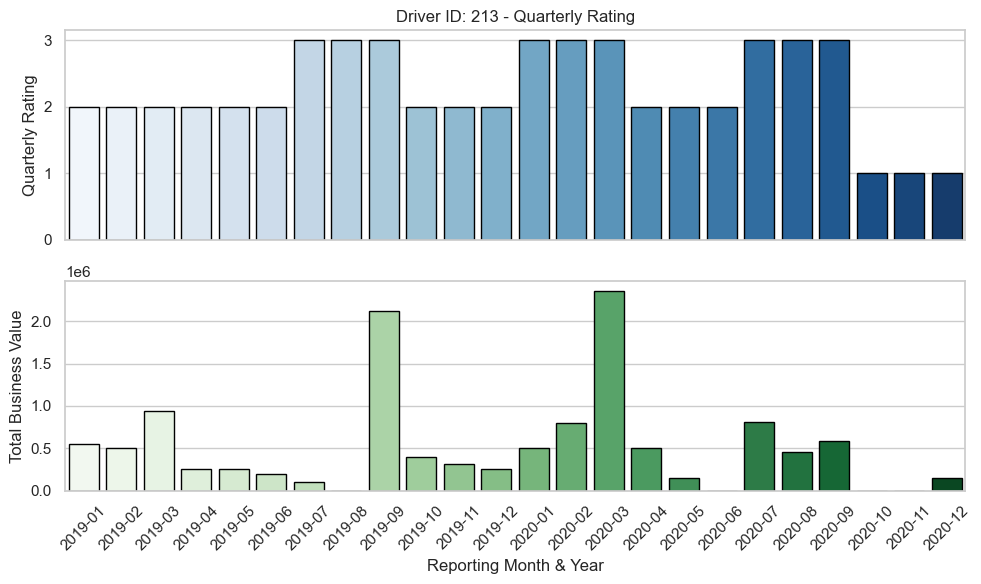

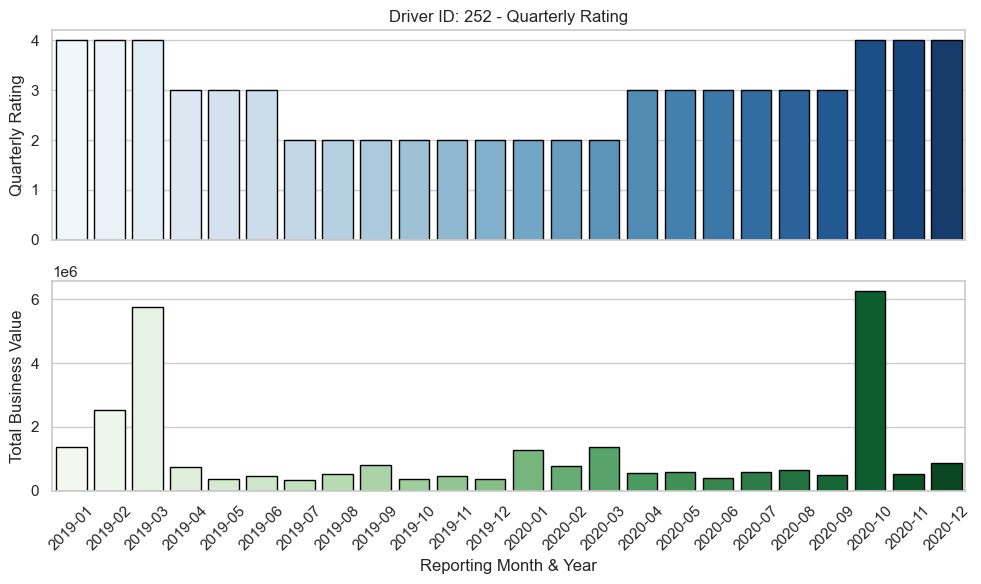

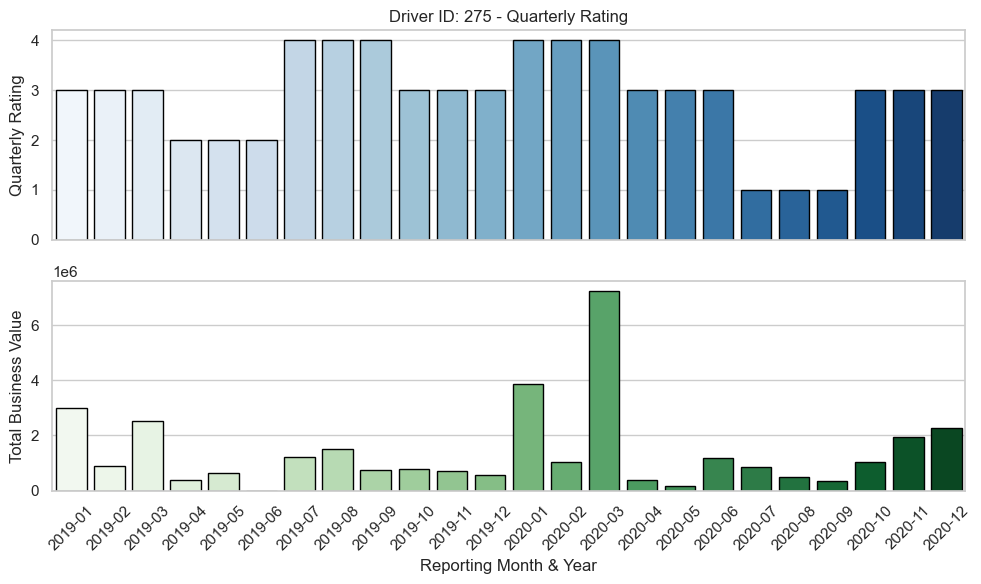

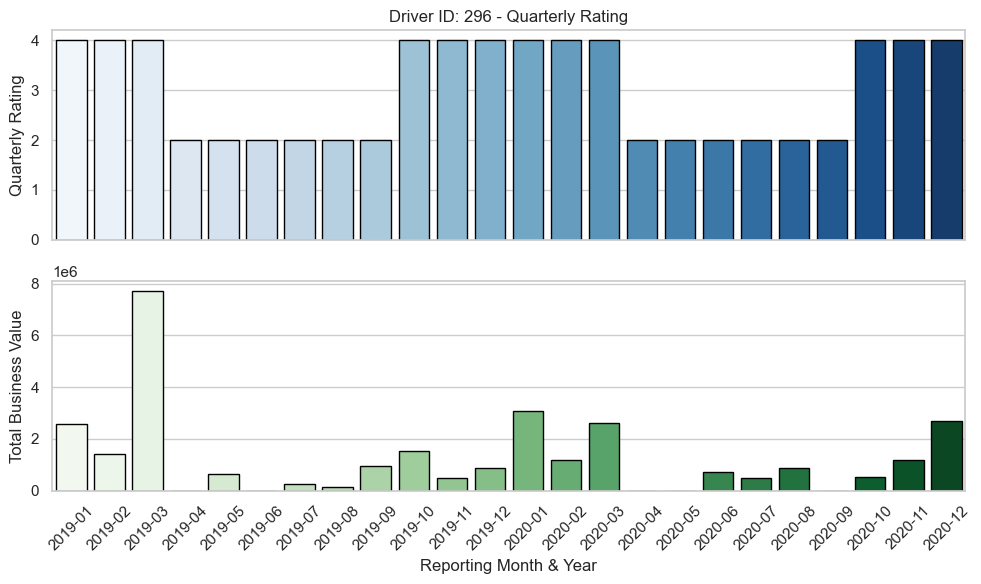

In [72]:
# Filter drivers with at least 2 years of service
temp_driver_full_service_df = temp_df[temp_df['Driver_ID'].isin(drivers_with_2_year_service)]

# Limit to first 20 unique drivers
num_of_drivers = 20
sample_drivers = temp_driver_full_service_df['Driver_ID'].unique()[:num_of_drivers]

# Seaborn theme for cleaner visuals
sns.set_theme(style="whitegrid")

# Loop through selected drivers
for driver_id in sample_drivers:
    sample_df = temp_driver_full_service_df[temp_driver_full_service_df['Driver_ID'] == driver_id].copy()
    
    # Ensure ReportingMonthYear is sorted correctly
    sample_df['ReportingMonthYear'] = pd.Categorical(
        sample_df['ReportingMonthYear'], 
        categories=sorted(sample_df['ReportingMonthYear'].unique()), 
        ordered=True
    )
    
    # Create subplots
    fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
    
    # Plot Quarterly Rating
    sns.barplot(ax=axs[0], data=sample_df, x='ReportingMonthYear', y='Quarterly Rating', palette='Blues', edgecolor='black')
    axs[0].set_ylabel("Quarterly Rating")
    axs[0].set_title(f'Driver ID: {driver_id} - Quarterly Rating')

    # Plot Total Business Value
    sns.barplot(ax=axs[1], data=sample_df, x='ReportingMonthYear', y='Total Business Value', palette='Greens', edgecolor='black')
    axs[1].set_ylabel("Total Business Value")
    axs[1].set_xlabel("Reporting Month & Year")

    # Rotate x-axis labels for readability
    plt.xticks(rotation=45)
    
    # Adjust layout
    plt.tight_layout()
    
    # Show plot
    plt.show()


### <span style="color:seagreen"><strong>Insights:</strong></span>
- It can be observed that a significant drop in rating impacts the Total Business Value. Drop in rating demotivates the drivers, leading to accepting only a few rides or in somecases not accepting any rides and hence impacting the Total Business Value

### Multivariate analysis

In [75]:
driver_df['Gender'].replace({'Male':0, 'Female':1}, inplace=True)
driver_df['Education_Level'].replace({'Graduate':0, '10+':1, '12+':2}, inplace=True)
driver_df['City'] = driver_df['City'].str[1:]

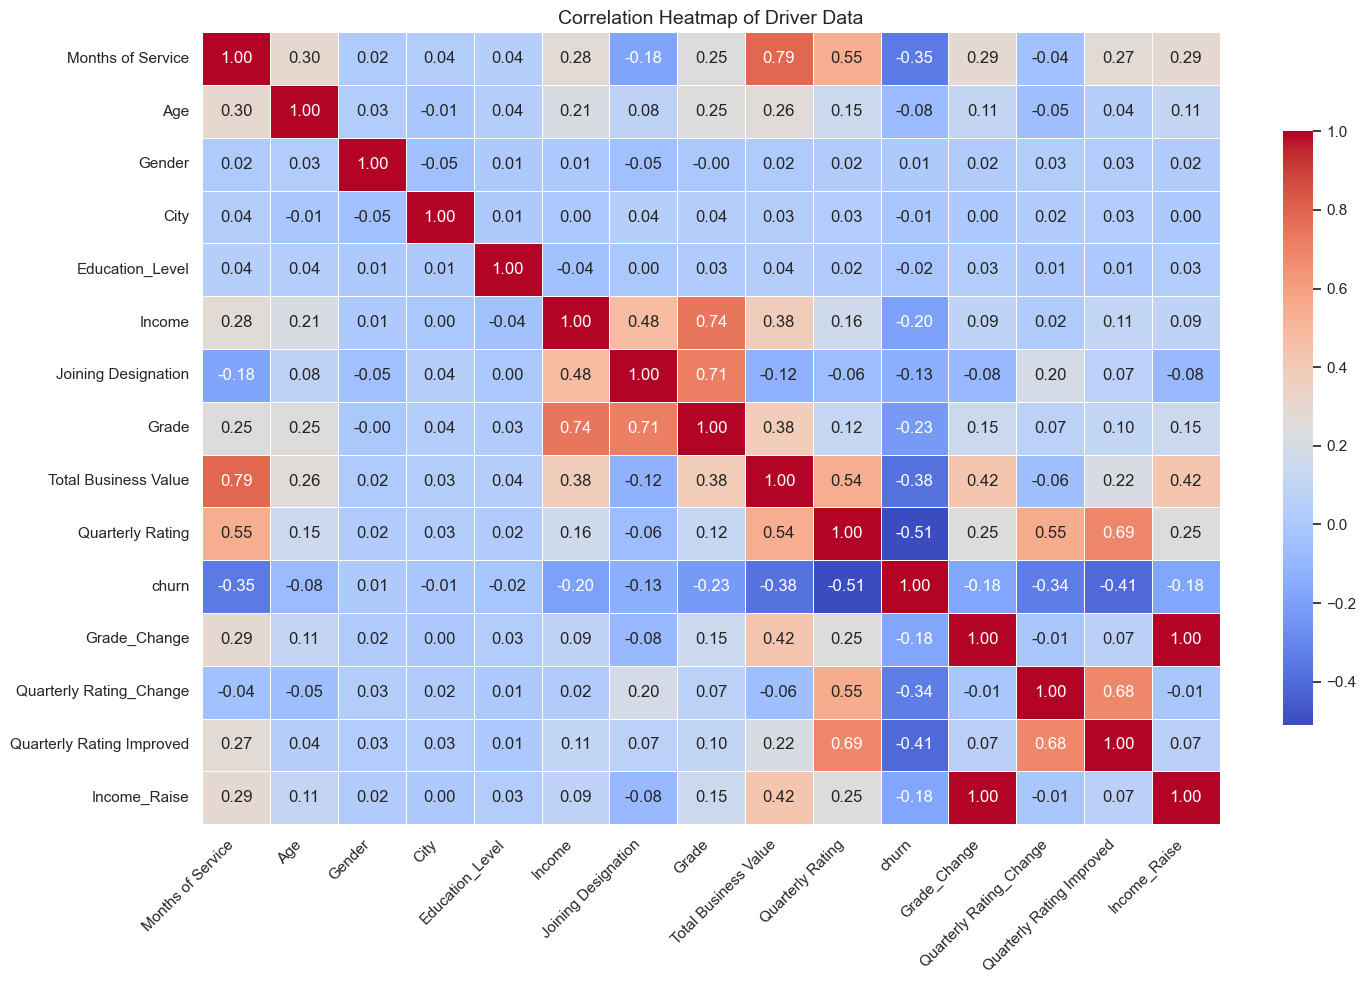

In [76]:
# Set Seaborn theme for better visuals
sns.set_theme(style="white")

# Compute correlation matrix excluding non-numeric columns
corr_matrix = driver_df.drop(columns=['Driver_ID', 'Dateofjoining', 'LastWorkingDate', 'Income_Change']).corr()

# Create the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(
    corr_matrix, 
    annot=True, 
    cmap='coolwarm',  # Use a diverging colormap for better contrast
    fmt=".2f",  # Limit decimal places for readability
    linewidths=0.5,  # Add grid lines for better separation
    cbar_kws={'shrink': 0.75}  # Adjust color bar size
)

# Improve layout
plt.title("Correlation Heatmap of Driver Data", fontsize=14)
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for readability
plt.yticks(rotation=0)  # Keep y-axis labels horizontal
plt.tight_layout()

# Show plot
plt.show()


### <span style="color:seagreen"><strong>Insights:</strong></span>
- **Months of Service** and **Total Business Value** are highly correlated
- **Income** and **Grade** are highly correlated
- **Joining Designation** and **Grade** are highly correlated
- **Quarterly Rating** and **Months of Service** are highly correlated
- **Chrun** is decently correlated with **Quarterly Rating, Total Business Value, Months of Service**

## Data Preprocessing

In [79]:
driver_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Driver_ID                  2381 non-null   int64         
 1   Months of Service          2381 non-null   int64         
 2   Age                        2381 non-null   float64       
 3   Gender                     2381 non-null   category      
 4   City                       2381 non-null   object        
 5   Education_Level            2381 non-null   category      
 6   Income                     2381 non-null   int64         
 7   Dateofjoining              2381 non-null   datetime64[ns]
 8   LastWorkingDate            1616 non-null   datetime64[ns]
 9   Joining Designation        2381 non-null   category      
 10  Grade                      2381 non-null   category      
 11  Total Business Value       2381 non-null   int64         
 12  Quarte

### <span style="color:seagreen"><strong>Insights:</strong></span>
- The columns **Driver_ID, Gender, City, Education_Level, Dateofjoining, LastWorkingDate** can be dropped as they do not contribute towards the driver churn rate

In [81]:
driver_df.drop(columns=['Driver_ID', 'Gender', 'City', 'Education_Level', 'Dateofjoining', 'LastWorkingDate', 'Income_Change'], inplace=True)
driver_df['Quarterly Rating'] = driver_df['Quarterly Rating'].astype('category')
driver_df['churn'] = driver_df['churn'].astype('category')
driver_df['Grade_Change'] = driver_df['Grade_Change'].astype('category')
driver_df['Quarterly Rating_Change'] = driver_df['Quarterly Rating_Change'].astype('category')
driver_df['Income_Raise'] = driver_df['Income_Raise'].astype('category')
driver_df.head()

,Months of Service,Age,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating,churn,Grade_Change,Quarterly Rating_Change,Quarterly Rating Improved,Income_Raise
0,3,28.0,57387,1,1,1715580,2,1,0,0,0,0
1,2,31.0,67016,2,2,0,1,0,0,0,0,0
2,5,43.0,65603,2,2,350000,1,1,0,0,0,0
3,3,29.0,46368,1,1,120360,1,1,0,0,0,0
4,5,31.0,78728,3,3,1265000,2,0,0,1,1,0


#### a. Duplicate value check

In [83]:
driver_df.duplicated().value_counts()

False    2381
Name: count, dtype: int64

### <span style="color:seagreen"><strong>Insights:</strong></span>
- There are no duplicates

#### b. Missing value treatment

In [86]:
driver_df.isna().sum()

Months of Service            0
Age                          0
Income                       0
Joining Designation          0
Grade                        0
Total Business Value         0
Quarterly Rating             0
churn                        0
Grade_Change                 0
Quarterly Rating_Change      0
Quarterly Rating Improved    0
Income_Raise                 0
dtype: int64

### <span style="color:seagreen"><strong>Insights:</strong></span>
- There are **no missing data or null values**

#### c. Outlier treatment

In [89]:
num_columns = driver_df.select_dtypes(include=np.number).columns

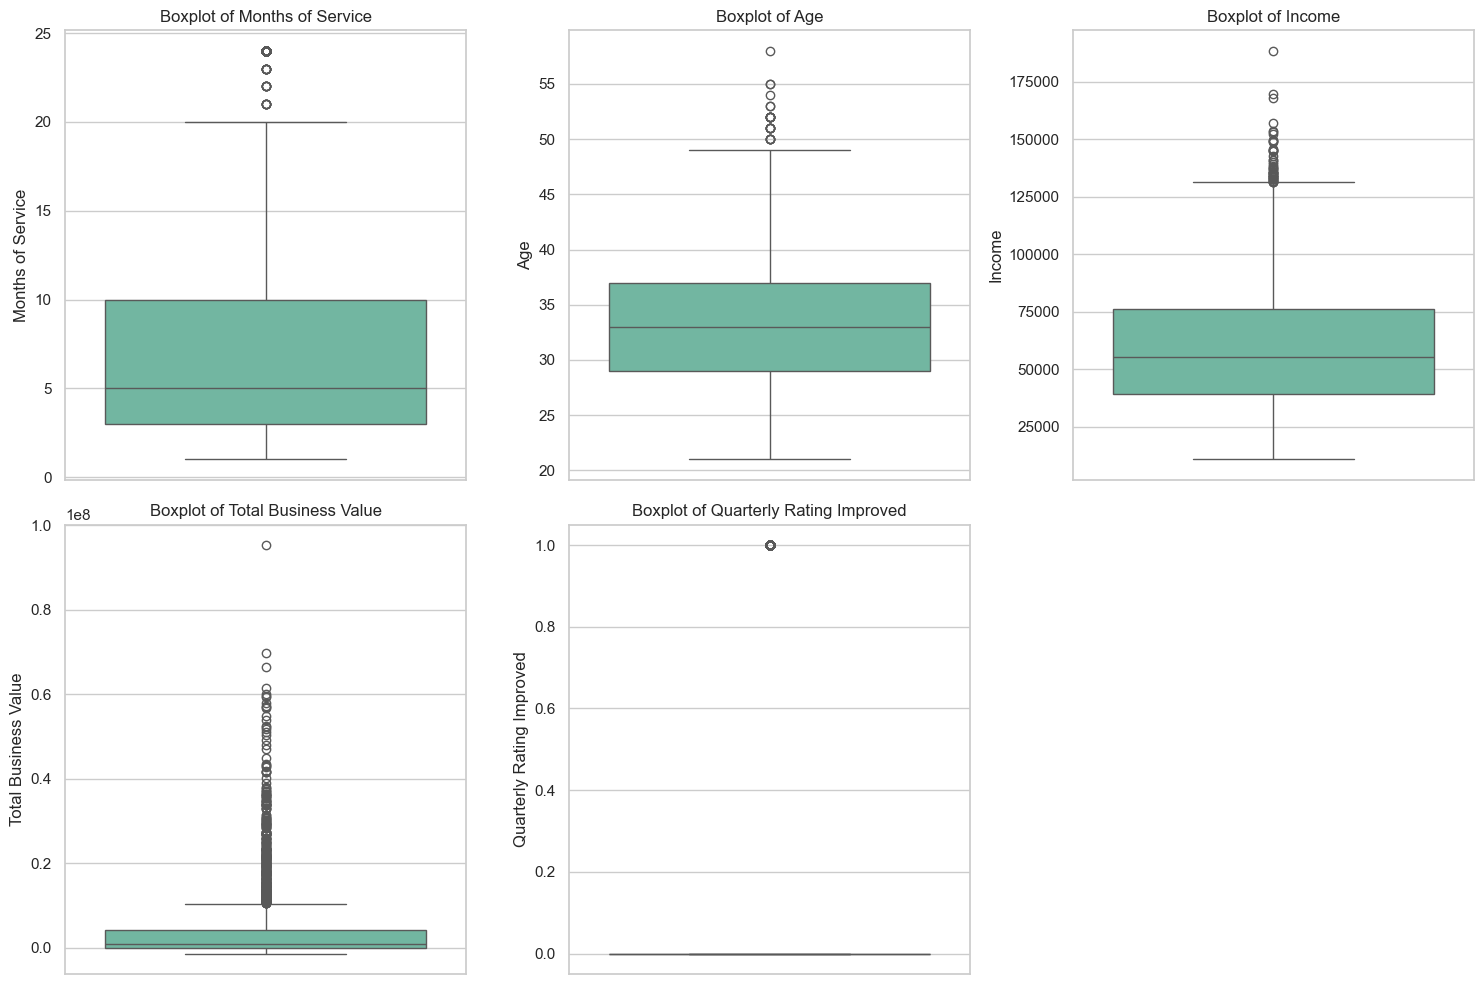

In [90]:
# Set Seaborn theme for better aesthetics
sns.set_theme(style="whitegrid")

# Define the number of rows and columns for subplots dynamically
num_cols = len(num_columns)
rows = (num_cols // 3) + (num_cols % 3 > 0)  # Ensures proper row count for grid

# Create subplots
fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))  # Dynamically adjust figure size
axes = axes.flatten()  # Flatten for easy indexing

# Loop through numerical columns and create boxplots
for i, col in enumerate(num_columns):
    sns.boxplot(y=driver_df[col], ax=axes[i], palette="Set2")
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_ylabel(col)

# Hide empty subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()


In [91]:
## detect outiler using iqr

# Compute Q1, Q3, and IQR for each numeric column
Q1 = driver_df[num_columns].quantile(0.25)
Q3 = driver_df[num_columns].quantile(0.75)
IQR = Q3 - Q1

# Calculate lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
lower_outliers = driver_df[num_columns] < lower_bound
higher_outliers = driver_df[num_columns] > upper_bound

# Create dictionary to store outlier values
outlier_dictionary = {
    col: [driver_df[col][lower_outliers[col]], driver_df[col][higher_outliers[col]]]
    for col in num_columns
}

# Print outlier count for each column
for col, (low_out, high_out) in outlier_dictionary.items():
    print(f"The column '{col}' has {len(low_out) + len(high_out)} outliers")

# Alternatively, use IQR-based clipping to cap extreme values
driver_df[num_columns] = driver_df[num_columns].apply(lambda x: np.clip(x, lower_bound[x.name], upper_bound[x.name]))

# Check if any outliers are still present after clipping
outliers_present = (driver_df[num_columns] > upper_bound) | (driver_df[num_columns] < lower_bound)
data_contains_outliers = outliers_present.any().any()

print("Outliers present after clipping (IQR-based):", data_contains_outliers)


The column 'Months of Service' has 249 outliers
The column 'Age' has 25 outliers
The column 'Income' has 48 outliers
The column 'Total Business Value' has 336 outliers
The column 'Quarterly Rating Improved' has 358 outliers
Outliers present after clipping (IQR-based): False


In [92]:
## detect outiler using std
# Compute mean and standard deviation for each numeric column
mean = driver_df[num_columns].mean()
std = driver_df[num_columns].std()

# Calculate lower and upper limits using the 3-sigma rule
lower_limit = mean - (3 * std)
upper_limit = mean + (3 * std)

# Identify outliers
lower_outliers = driver_df[num_columns] < lower_limit
higher_outliers = driver_df[num_columns] > upper_limit

# Store outliers in a dictionary
outlier_dictionary = {
    col: [driver_df[col][lower_outliers[col]], driver_df[col][higher_outliers[col]]]
    for col in num_columns
}

# Print the number of outliers in each column
for col, (low_out, high_out) in outlier_dictionary.items():
    print(f"The column '{col}' has {len(low_out) + len(high_out)} outliers")

# Alternatively, use standard deviation-based clipping to cap extreme values
driver_df[num_columns] = driver_df[num_columns].apply(lambda x: np.clip(x, lower_limit[x.name], upper_limit[x.name]))

# Check if any outliers are still present after clipping
outliers_present = (driver_df[num_columns] > upper_limit) | (driver_df[num_columns] < lower_limit)
data_contains_outliers = outliers_present.any().any()

print("Outliers present after clipping (3-sigma rule):", data_contains_outliers)


The column 'Months of Service' has 0 outliers
The column 'Age' has 0 outliers
The column 'Income' has 0 outliers
The column 'Total Business Value' has 0 outliers
The column 'Quarterly Rating Improved' has 0 outliers
Outliers present after clipping (3-sigma rule): False


### <span style="color:seagreen"><strong>Insights:</strong></span>
- we detected outlier for column **Months of Service** has **249** outliers , column **Age** has **25** outliers ,column **Income** has **48** outliers,column **Total Business Value** has **336** outliers and column **Quarterly Rating Improved** has **358** outliers.
- we did outlier treatment on above columns

In [94]:
## Multicollinearity Check
features_df = driver_df.drop(columns=['churn']) # Drop churn column
features_df = features_df.drop(columns=features_df.select_dtypes(include='category').columns) # Drop category columns
features_df = sm.add_constant(features_df)  # Adding a constant column for the intercept
vif_df = pd.DataFrame()
vif_df['Features'] = features_df.columns
vif_df['VIF'] = [variance_inflation_factor(features_df.values, idx) for idx in range(len(features_df.columns))]
vif_df['VIF'] = round(vif_df['VIF'], 2)
vif_df = vif_df.sort_values(by='VIF', ascending=False)
vif_df           

,Features,VIF
0,const,37.34
4,Total Business Value,5.89
1,Months of Service,5.74
3,Income,1.13
2,Age,1.12
5,Quarterly Rating Improved,NaN


In [95]:
driver_df.columns

Index(['Months of Service', 'Age', 'Income', 'Joining Designation', 'Grade',
       'Total Business Value', 'Quarterly Rating', 'churn', 'Grade_Change',
       'Quarterly Rating_Change', 'Quarterly Rating Improved', 'Income_Raise'],
      dtype='object')

### <span style="color:seagreen"><strong>Insights:</strong></span>
- Based on the above VIF scores, I can conclude that there are no multicolinear numerical features

### Encode categorical variables

In [98]:
final_df = driver_df.copy()

**Sepearte out churn and feature columns**

In [100]:
X = final_df.drop(columns=['churn'])
y = final_df['churn']
X.shape, y.shape

((2381, 11), (2381,))

**Encode churn variable**

In [102]:
y = y.astype(int)

**Encode features with just 2 classes as 0 or 1**

In [104]:
X[['Grade_Change','Quarterly Rating_Change', 'Income_Raise']] = X[['Grade_Change','Quarterly Rating_Change', 'Income_Raise']].astype('int8')

**One-Hot-Encoding for remaining categorical features**

In [106]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Months of Service          2381 non-null   float64 
 1   Age                        2381 non-null   float64 
 2   Income                     2381 non-null   int64   
 3   Joining Designation        2381 non-null   category
 4   Grade                      2381 non-null   category
 5   Total Business Value       2381 non-null   int64   
 6   Quarterly Rating           2381 non-null   category
 7   Grade_Change               2381 non-null   int8    
 8   Quarterly Rating_Change    2381 non-null   int8    
 9   Quarterly Rating Improved  2381 non-null   int64   
 10  Income_Raise               2381 non-null   int8    
dtypes: category(3), float64(2), int64(3), int8(3)
memory usage: 107.7 KB


In [107]:
categorical_columns = X.select_dtypes(include='category').columns
categorical_columns

Index(['Joining Designation', 'Grade', 'Quarterly Rating'], dtype='object')

In [108]:
encoder = OneHotEncoder(sparse_output=False)
encoded_data = encoder.fit_transform(X[categorical_columns])
encoded_df = pd.DataFrame(encoded_data, columns = encoder.get_feature_names_out(categorical_columns))
X = pd.concat([X, encoded_df], axis=1)
X.drop(columns = categorical_columns, inplace=True)
X.head()

,Months of Service,Age,Income,Total Business Value,Grade_Change,Quarterly Rating_Change,Quarterly Rating Improved,Income_Raise,Joining Designation_1,Joining Designation_2,...,Joining Designation_5,Grade_1,Grade_2,Grade_3,Grade_4,Grade_5,Quarterly Rating_1,Quarterly Rating_2,Quarterly Rating_3,Quarterly Rating_4
0,3.0,28.0,57387,1715580,0,0,0,0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2.0,31.0,67016,0,0,0,0,0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,5.0,43.0,65603,350000,0,0,0,0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,3.0,29.0,46368,120360,0,0,0,0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,5.0,31.0,78728,1265000,0,1,0,0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


## Model building

### Train-test split

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1904, 22), (477, 22), (1904,), (477,))

### Perform data normalization/standardization
Data normalization/standardization is required so that features with higher scales do not dominate the model's performance. Hence all features should have same scale

**Data before scaling**

In [114]:
X_train.head()

,Months of Service,Age,Income,Total Business Value,Grade_Change,Quarterly Rating_Change,Quarterly Rating Improved,Income_Raise,Joining Designation_1,Joining Designation_2,...,Joining Designation_5,Grade_1,Grade_2,Grade_3,Grade_4,Grade_5,Quarterly Rating_1,Quarterly Rating_2,Quarterly Rating_3,Quarterly Rating_4
2236,7.0,28.0,57164,1092560,0,0,0,0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6,1.0,28.0,42172,0,0,0,0,0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1818,1.0,29.0,43989,0,0,0,0,0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1534,7.0,40.0,59636,2589640,0,0,0,0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2123,6.0,25.0,29052,2172260,0,0,0,0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [115]:
min_max_scaler = MinMaxScaler()
# Fit min_max_scaler to training data
min_max_scaler.fit(X_train)
# Scale the training and testing data
X_train = pd.DataFrame(min_max_scaler.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(min_max_scaler.transform(X_test), columns=X_test.columns)

**Data after scaling**

In [117]:
X_train.head()

,Months of Service,Age,Income,Total Business Value,Grade_Change,Quarterly Rating_Change,Quarterly Rating Improved,Income_Raise,Joining Designation_1,Joining Designation_2,...,Joining Designation_5,Grade_1,Grade_2,Grade_3,Grade_4,Grade_5,Quarterly Rating_1,Quarterly Rating_2,Quarterly Rating_3,Quarterly Rating_4
0,0.307692,0.250000,0.385005,0.209658,0.0,0.5,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.000000,0.250000,0.260654,0.117223,0.0,0.5,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.000000,0.285714,0.275725,0.117223,0.0,0.5,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.307692,0.678571,0.405509,0.336319,0.0,0.5,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.256410,0.142857,0.151831,0.301006,0.0,0.5,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


**Check for imbalance in churn class**

In [119]:
y_train.value_counts(normalize=True)*100

churn
1    68.644958
0    31.355042
Name: proportion, dtype: float64

We can see a clear imbalance in the churn class with **1** being **~69%** and **0** being **~31%**. Hence, I will use **SMOTE** to fix this imbalance

In [121]:
sm = SMOTE(random_state=0)
X_train, y_train = sm.fit_resample(X_train, y_train)
y_train.value_counts(normalize=True)*100

churn
1    50.0
0    50.0
Name: proportion, dtype: float64

### Ensemble Learning: Bagging - RandomForestClassifier
A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.\
The hyper-parameters of the random forest classifier will be selected using grid search cross validation

In [123]:
# Define parameter grid
param_grid = {
    'n_estimators': list(range(100, 1000, 100)),
    'max_features': ['sqrt', 'log2'],
    'max_depth': list(range(10, 100, 10)),
    'min_samples_split': list(range(2, 10, 1))
}

# Initialize classifier and RandomizedSearchCV
rf = RandomForestClassifier()
rf_random = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1)

# Fit the model
rf_random.fit(X_train, y_train)

# Evaluate best parameters
print("Best parameters found: ", rf_random.best_params_)

Fitting 3 folds for each of 1296 candidates, totalling 3888 fits
Best parameters found:  {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 400}


In [124]:
color = '\033[91m'
bold = '\033[1m'
end = '\033[0m'
# Predict and evaluate performance
y_true = y_train
y_pred = rf_random.predict(X_train)
print(color + bold + "Train data:" + color + end)
print("Accuracy: ", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))
y_true = y_test
y_pred = rf_random.predict(X_test)
print(color + bold + "Test data:" + color + end)
print("Accuracy: ", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))

Train data:
Accuracy:  1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1307
           1       1.00      1.00      1.00      1307

    accuracy                           1.00      2614
   macro avg       1.00      1.00      1.00      2614
weighted avg       1.00      1.00      1.00      2614

Test data:
Accuracy:  0.7693920335429769
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.64      0.66       168
           1       0.81      0.84      0.83       309

    accuracy                           0.77       477
   macro avg       0.75      0.74      0.74       477
weighted avg       0.77      0.77      0.77       477



### <span style="color:seagreen"><strong>Insights:</strong></span>
- The training accuracy is 1 whereas testing accuracy is 0.778. This is a case of **overfitting**.
- The best parameters found are well within the provided range

In [126]:
def plot_feature_importance(estimator, features):
    # Extract feature importances
    importances = estimator.feature_importances_

    # Create a DatafRame for plotting
    feature_importance_df = pd.DataFrame({'Feature':features, 'Importance':importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(8,5))
    sns.barplot(data=feature_importance_df, x='Importance', y='Feature')
    plt.title('Feature Importance')
    plt.show()

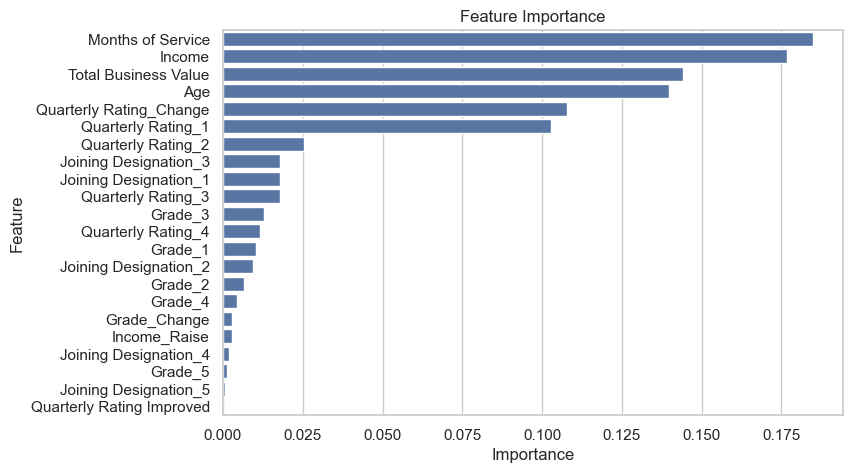

In [127]:
plot_feature_importance(rf_random.best_estimator_, X_train.columns)

### Confusion Matrix

In [129]:
def display_confusion_matrix(y_test, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

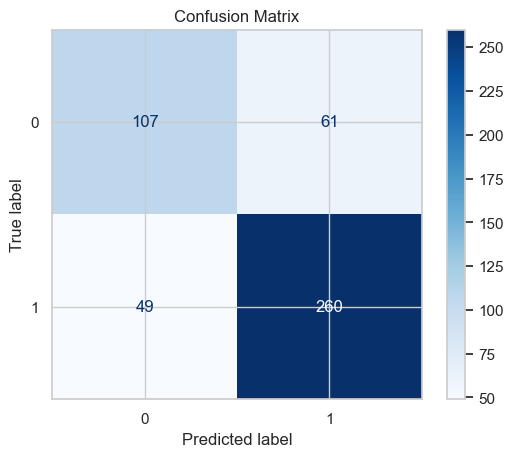

In [130]:
display_confusion_matrix(y_test, y_pred)

### ROC Curve

In [132]:
def plot_roc_curve(estimator, X_train, X_test, y_train, y_test):
    # Binarize the output
    y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])
    n_classes = y_test_binarized.shape[1]-1

    # Compute ROC curve and ROC area for each class
    classifier = OneVsRestClassifier(estimator)
    y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(5, 5))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()    

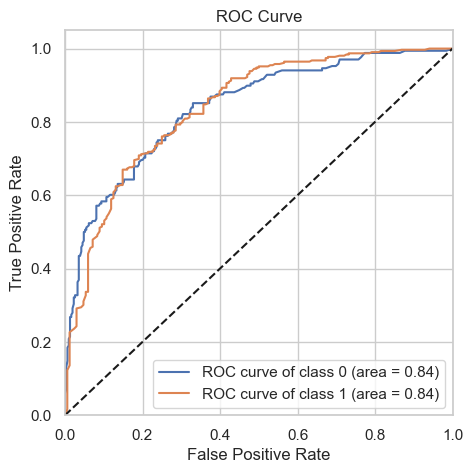

In [133]:
plot_roc_curve(rf_random.best_estimator_, X_train, X_test, y_train, y_test)

### Precision-Recall Curve

In [135]:
def plot_pr_curve(estimator, X_train, X_test, y_train, y_test):
    # Binarize the output
    y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])
    n_classes = y_test_binarized.shape[1]-1

    # Compute ROC curve and ROC area for each class
    classifier = OneVsRestClassifier(estimator)
    y_score = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i], y_score[:, i])
        average_precision[i] = average_precision_score(y_test_binarized[:, i], y_score[:, i])

    # Plot Precision-Recall curve for each class
    plt.figure(figsize=(5, 5))
    for i in range(n_classes):
        plt.plot(recall[i], precision[i], label='PR curve of class {0} (area = {1:0.2f})'.format(i, average_precision[i]))

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower right')
    plt.show()

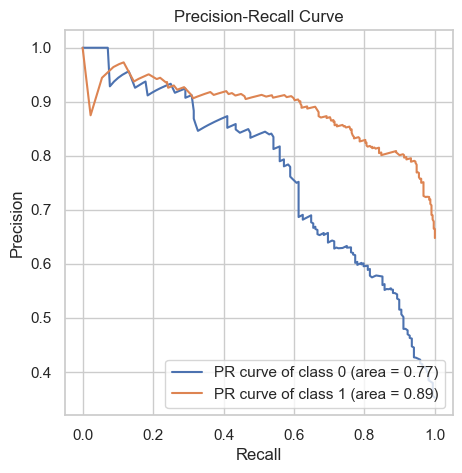

In [136]:
plot_pr_curve(rf_random.best_estimator_, X_train, X_test, y_train, y_test)

### <span style="color:seagreen"><strong>Insights:</strong></span>
- The **top 5 features** as per the RandomForestCLassifier are \
--**Months of Service \
--Income \
--Total Business Value \
--Age\
--Quarterly Rating 1**
- Both the classes 0 and 1 have a decent **Area Under the ROC** curve of **0.85**
- The **Area Under the PR** curve for class 0 is **0.77** and class 1 is **0.90**

## Ensemble Learning: Boosting - GradientBoostingClassifier
This algorithm builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions. In each stage n_classes_ regression trees are fit on the negative gradient of the loss function, e.g. binary or multiclass log loss.\
The hyper-parameters of the GradientBoostingClassifier will be selected using random search cross validation

In [139]:
# Define parameter grid
param_grid = {
    'n_estimators': np.arange(100, 1001, 100),
    'learning_rate': np.logspace(-3, 0, 10),
    'max_depth': np.arange(3, 11, 1),
    'min_samples_split': np.arange(2, 21, 2),
    'min_samples_leaf': np.arange(1, 21, 2),
    'subsample': np.linspace(0.5, 1.0, 6)
}

# Initialize classifier and RandomizedSearchCV
gb = GradientBoostingClassifier()
gb_random = RandomizedSearchCV(estimator=gb, param_distributions=param_grid,
                                n_iter=300, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit the model
gb_random.fit(X_train, y_train)

# Evaluate best parameters
print("Best parameters found for GradientBoostingClassifier: ", gb_random.best_params_)

Fitting 3 folds for each of 300 candidates, totalling 900 fits
Best parameters found for GradientBoostingClassifier:  {'subsample': 0.5, 'n_estimators': 800, 'min_samples_split': 20, 'min_samples_leaf': 3, 'max_depth': 10, 'learning_rate': 0.004641588833612777}


In [140]:
color = '\033[91m'
bold = '\033[1m'
end = '\033[0m'
# Predict and evaluate performance
y_true = y_train
y_pred = gb_random.predict(X_train)
print(color + bold + "Train data:" + color + end)
print("Accuracy: ", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))
y_true = y_test
y_pred = gb_random.predict(X_test)
print(color + bold + "Test data:" + color + end)
print("Accuracy: ", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))

Train data:
Accuracy:  0.9483550114766641
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95      1307
           1       0.94      0.96      0.95      1307

    accuracy                           0.95      2614
   macro avg       0.95      0.95      0.95      2614
weighted avg       0.95      0.95      0.95      2614

Test data:
Accuracy:  0.7819706498951782
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.63      0.67       168
           1       0.81      0.86      0.84       309

    accuracy                           0.78       477
   macro avg       0.76      0.75      0.75       477
weighted avg       0.78      0.78      0.78       477



### <span style="color:seagreen"><strong>Insights:</strong></span>
- The training accuracy is 1 whereas testing accuracy is 0.786. This is also a case of **overfitting**.

### Performance

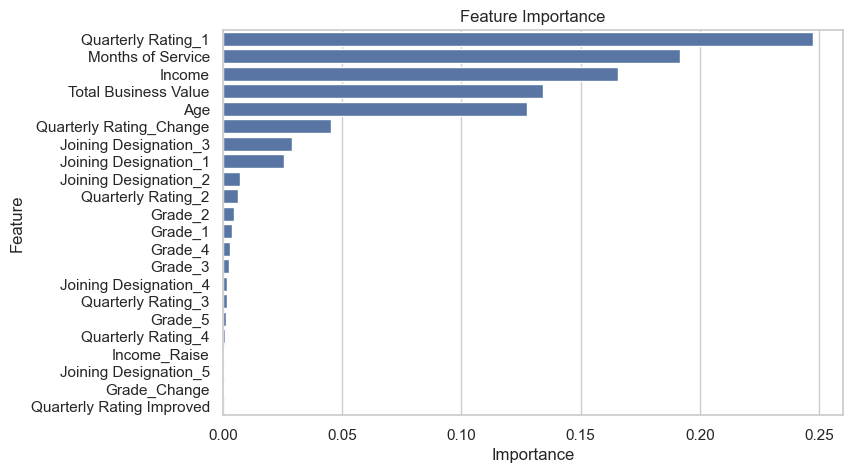

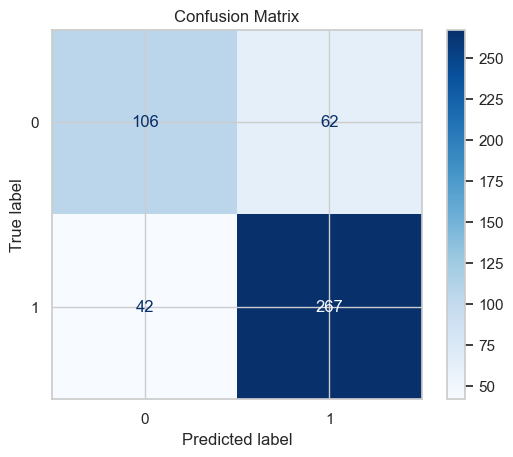

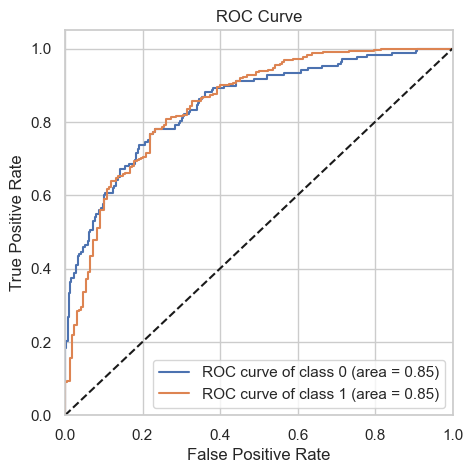

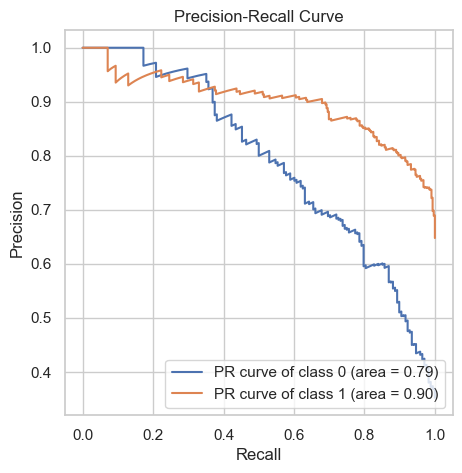

In [143]:
plot_feature_importance(gb_random.best_estimator_, X_train.columns)
display_confusion_matrix(y_test, y_pred)
plot_roc_curve(gb_random.best_estimator_, X_train, X_test, y_train, y_test)
plot_pr_curve(gb_random.best_estimator_, X_train, X_test, y_train, y_test)

### <span style="color:seagreen"><strong>Insights:</strong></span>
- The **top 5 features** as per the GradientBoostingClassifier are \
--**Quarterly Rating 1 \
--Months of Service \
--Income \
--Total Business Value \
--Age**
- Both the classes 0 and 1 have a decent **Area Under the ROC** curve of **0.85**
- The **Area Under the PR** curve for class 0 is **0.79** and class 1 is **0.91**

## Ensemble Learning: Boosting - XGBClassifier
XGBClassifier is a highly optimized version of GBM. It includes regularization to prevent overfitting and various other enhancements.\
The hyper-parameters of the XGBClassifier will be selected using random search cross validation

In [146]:
# Define parameter grid
param_grid = {
    'n_estimators': np.arange(100, 1001, 100),
    'learning_rate': np.logspace(-3, 0, 10),
    'max_depth': np.arange(3, 11, 1),
    'min_child_weight': np.arange(1, 11, 1),
    'gamma': np.logspace(-3, 1, 10),
    'subsample': np.linspace(0.5, 1.0, 6),
    'colsample_bytree': np.linspace(0.5, 1.0, 6)
}


# Initialize classifier and RandomizedSearchCV
xgb = XGBClassifier(eval_metric='mlogloss')
xgb_random = RandomizedSearchCV(estimator=xgb, param_distributions=param_grid,
                                n_iter=300, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit the model
xgb_random.fit(X_train, y_train)

# Evaluate best parameters
print("Best parameters found for XGBoost: ", xgb_random.best_params_)

Fitting 3 folds for each of 300 candidates, totalling 900 fits
Best parameters found for XGBoost:  {'subsample': 0.6, 'n_estimators': 500, 'min_child_weight': 2, 'max_depth': 8, 'learning_rate': 0.21544346900318823, 'gamma': 0.0027825594022071257, 'colsample_bytree': 0.6}


In [147]:
color = '\033[91m'
bold = '\033[1m'
end = '\033[0m'
# Predict and evaluate performance
y_true = y_train
y_pred = xgb_random.predict(X_train)
print(color + bold + "Train data:" + color + end)
print("Accuracy: ", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))
y_true = y_test
y_pred = xgb_random.predict(X_test)
print(color + bold + "Test data:" + color + end)
print("Accuracy: ", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))

Train data:
Accuracy:  0.9969395562356542
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1307
           1       1.00      1.00      1.00      1307

    accuracy                           1.00      2614
   macro avg       1.00      1.00      1.00      2614
weighted avg       1.00      1.00      1.00      2614

Test data:
Accuracy:  0.7819706498951782
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.66      0.68       168
           1       0.82      0.85      0.83       309

    accuracy                           0.78       477
   macro avg       0.76      0.75      0.76       477
weighted avg       0.78      0.78      0.78       477



### <span style="color:seagreen"><strong>Insights:</strong></span>
- The training accuracy has reduced to 0.939 whereas testing accuracy has slightly increased to 0.813. This is still a case of **overfitting** but better than all the previous models.
- This model is also faster than the previous models

### Performance

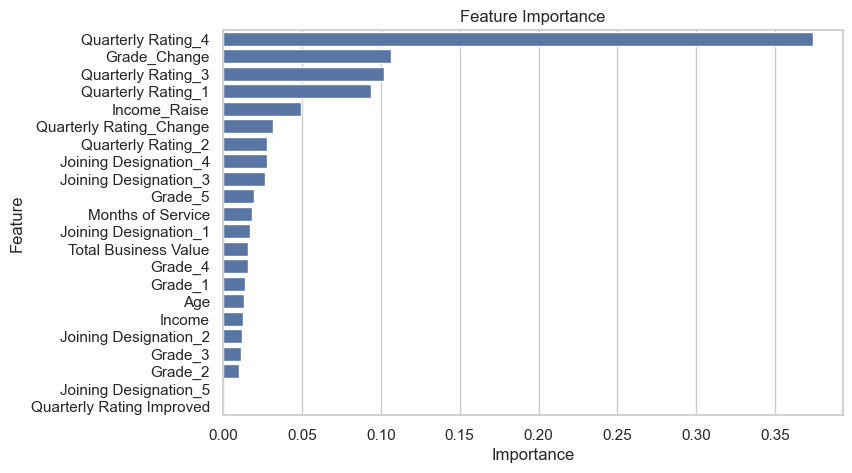

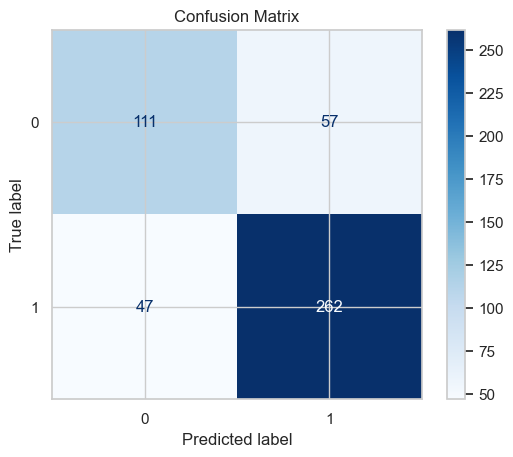

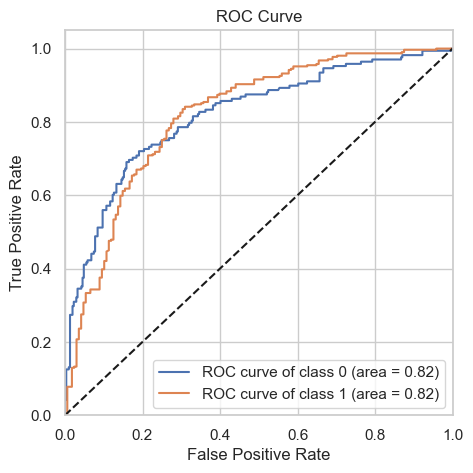

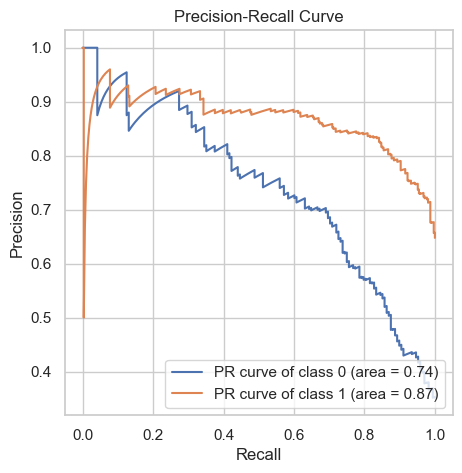

In [150]:
plot_feature_importance(xgb_random.best_estimator_, X_train.columns)
display_confusion_matrix(y_test, y_pred)
plot_roc_curve(xgb_random.best_estimator_, X_train, X_test, y_train, y_test)
plot_pr_curve(xgb_random.best_estimator_, X_train, X_test, y_train, y_test)

### <span style="color:seagreen"><strong>Insights:</strong></span>
- The **top 5 features** as per the XGBClassifier are \
--**Quarterly Rating 1 \
--Quarterly Rating Improved \
--Quarterly Rating 4 \
--Months of Service \
--Quarterly Rating_Change**\
- Both the classes 0 and 1 have a decent **Area Under the ROC** curve of **0.86**
- The **Area Under the PR** curve for class 0 is **0.81** and class 1 is **0.90**

# 7. Insights

- **Most** of the drivers are in the age group of **30 to 35**
- **59%** of the drivers are **Male** and remaining **41%** are **Female**
- City **C20** has the **maximum** number of **drivers**
- Maximum number of drivers joined in the year **2020** and in the month of **July**
- 1026 drivers have a **joining designation of 1**
- Maximum number of drivers have a **grade of 2**
- **Majority** of the drivers have a very **low quarterly rating of 1**
- There are **no drivers** with quarterly rating of **5**
- **1616** drivers have **churned**, which is around **68%**
- The **median income** of drivers who have **churned** is **lesser** than that of the drivers who have not churned
- The **churn rate** is **very less** in drivers whose **income has raised**
- The **churn rate** is **very less** in drivers whose **grade has raised**
- The **churn rate** is **very less** in drivers whose **Quarterly rating has increased**

 # 8. Recommendation
 - The quartely rating has been the top contibutor on deciding if a driver will churn or not. As the ratings are given by the customers to the driver, Ola should urge all customers to rate the drivers on time. Ola should provide incentives/points to the customers to encourage timely rating.
- Ola should make sure that the income of deserving drivers should be increased every 6 months, if not every quarter, to encourage drivers to stay
- Long service awards/bonuses should be given to drivers to keep them motivated
- Special trainings should be given to drivers on how to handle different customers and different situations so that the customers always provide positive ratings

 # 9. Questionnaire
### 9.1 What percentage of drivers have received a quarterly rating of 5?
**Ans:** No drivers have received a quarterly rating of 5 
### 9.2 Comment on the correlation between Age and Quarterly Rating.
**Ans:** Age and Quarterly rating do not have much correlation. They have a small correlation value of 0.15
### 9.3 Name the city which showed the most improvement in Quarterly Rating over the past year
**Ans:** The city C29 shows  most improvement in Quarterly Rating in 2020 compared to 2019
### 9.4 Drivers with a Grade of ‘A’ are more likely to have a higher Total Business Value. (T/F)
**Ans:** Yes, the mean of Total Business Value of drivers with grade 5(or A) is higher than those with other grades
### 9.5 If a driver's Quarterly Rating drops significantly, how does it impact their Total Business Value in the subsequent period?
**Ans:** A significant drop in rating leads to dip in the Total Business Value in the subsequesnt period. Drop in rating demotivates the drivers, leading to accepting only a few rides or in somecases not accepting any rides and hence impacting the Total Business Value
### 9.6 From Ola's perspective, which metric should be the primary focus for driver retention? 1. ROC AUC, 2. Precision, 3. Recall, 4. F1 Score
**Ans:** Recall. It is ok if the model predicts most drivers as **churn** but it should not predict **churn** drivers as **Not churn**
### 9.7 How does the gap in precision and recall affect Ola's relationship with its drivers and customers?
**Ans:** Gap in the precision and recall implies that the False Negatives and False Positives values are very different. If more instances of churn are misclassified as Not churn, then the customers may get drives who are not-motived/unsatisfied leading to bad customer experience. On the other hand if more instances of Not churn are misclassified as churn, then the good performing drivers will be neglected leading to driver dissatification.
### 9.8 Besides the obvious features like "Number of Rides", which lesser-discussed features might have a strong impact on a driver's Quarterly Rating?
**Ans:**
1) Customers not providing timely rating or providing false rating has a strong impact on high performing drivers and their quarterly rating.\
2) Lack of training to the driver on handling different situation can also impact their quarterly rating. Not all customers are same, so the driver needs to adapt his behaviour as per the customer.
### 9.9 Will the driver's performance be affected by the City they operate in? (Yes/No)
**Ans:** Yes, it might be the case that the people(customers) of a city are of a particular mindset. The people of a city could be more accomodative and provide good ratings always and people of a different city could get irriated easily and provide bad ratings
### 9.10 Analyze any seasonality in the driver's ratings. Do certain times of the year correspond to higher or lower ratings, and why might that be?
**Ans:** Yes, there is a seasonality in the driver's rating. The ratings dip in Q2 and then shoot up in Q3. This could be becuase of the holiday season in Q2 when many people move out of the cities for vacation and hence less usage of cabs.